In [101]:
# %load notebook_setup.py
#Use %load notebook_setup.py to load these commands at the top of your
#ipython notebook.  Includes running the std_libraries.py file. 

%run std_libraries.py
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
%matplotlib inline
#%matplotlib notebook

Importing yeast_esr_exp.  If autoreload, may need to reset base_dir and data_processing dir 
  yeast_esr_exp.base_dir=base_dir 
 yeast_esr_exp.data_processing_dir = data_processing_dir
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = othera
base directory is C:\Users\BMH_work\github\yeast_esr_expression_analysis
Importing yeast_esr_exp and setting base_dir and data_processing_dir
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
#Make kl_sc_PKA_data dataframe.  Only need to do once. 
#Compare both species AS +/- drug

# Combine data from both species
#eventually I might want a big database here but for now just going to load what I need. 


#Load KL to SC ortholog mapping

kl_orthologs = yeast_esr_exp.read_orth_lookup_table('Klac', 'Scer', data_processing_dir + os.sep + 'ortholog_files_YGOB' + os.sep)

kl_orthologs_from_sc = {}
for kl_genename, sc_orths in kl_orthologs.items():
    for sc_orth in sc_orths: 
        if sc_orth != 'NONE':
            kl_orthologs_from_sc[sc_orth]=kl_genename

kl_orthologs_from_sc_df = pd.Series(kl_orthologs_from_sc).to_frame(name='kl_genename')

#pd.read_pickle(data_processing_dir + "ortholog_files_YGOB/kl_orthologs.pkl")

#Load data for each species and combine desired data into one dataframe per species. 

lfc_data = {}
# rlog_data = {}
# raw_data = {}
comparison_data = {}

species = ['KL', 'SC']
# conditions = ["AS_noNMPP1_YPD_t40", "AS_yesNMPP1_YPD_t40"]
for spec in species: 
    #Load DEseq data for AS +/- drug
    #lfc_data_spec = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20181017_deseq_' + spec + '_AS_WT_nmpp1.csv'), index_col=0)
    lfc_data_spec = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20200603_deseq_' + spec + '_AS_WT_nmpp1.csv'), index_col=0)
    
    if spec == 'KL':
        kl_genenames = yeast_esr_exp.kl_genename_convert_list(lfc_data_spec.index)
        lfc_data_spec['kl_genename'] = kl_genenames
        lfc_data_spec.set_index('kl_genename',inplace = True)
    lfc_data_spec.index.name = spec.lower() + "_genename"
    
    lfc_data[spec] = lfc_data_spec

    #     fname_rlog_data = data_processing_dir + '20170817_klscpka/20170817_klscpka_avg_rlog_' + spec + '.csv'
    #     rlog_data[spec] = pd.read_csv(fname_rlog_data,index_col = 0)
    #     fname_raw_data = data_processing_dir + '20170817_klscpka/20170817_klscpka_avg_counts_' + spec + '.csv'
    #     raw_data[spec] = pd.read_csv(fname_raw_data,index_col = 0)

    #     #These are the genes that have no rlog value
    #     print('The following ' + str(len(set(lfc_data[spec].index)-set(rlog_data[spec].index))) + ' genes have no rlog data for ' + spec)
    #     print(set(lfc_data[spec].index)-set(rlog_data[spec].index))

    #     #Merge into one dataset
    #     labels_mean = [condition + "_mean" for condition in conditions]
    #     labels_var = [condition + "_var" for condition in conditions]
    #     labels = list(chain.from_iterable([labels_mean,labels_var]))

    #     rlog_subset = rlog_data[spec].loc[:,labels]
    #     rlog_subset.rename(index = str, columns = {label: 'rlog_' + label for label in labels},inplace=True)

    #     raw_subset = raw_data[spec].loc[:,labels]
    #     raw_subset.rename(index = str, columns = {label: 'raw_' + label for label in labels},inplace=True)
    
    comparison_data[spec] =  lfc_data_spec  #pd.concat([lfc_data[spec], rlog_subset , raw_subset],axis = 1)

#Map KL PKA inhibition data onto related SC orthologs
kl_comparison_data_sc_orthologs = kl_orthologs_from_sc_df.merge(comparison_data['KL'], left_on='kl_genename', right_index=True, how = 'inner')
print('{} genes with orthologs in K.lactis and RNA seq data for KL'.format(len(kl_comparison_data_sc_orthologs)))

#add in SC_common_name to SC data
sc_comparison_data=comparison_data['SC']
sc_comparison_data['SC_common_name']= yeast_esr_exp.SC_common_name_lookup(sc_comparison_data.index)
#Just noticed that IMP2 has a common name IMP2' - should troubleshoot that someday. 

kl_sc_PKA_data = kl_comparison_data_sc_orthologs.merge(sc_comparison_data, left_index=True, right_index=True,suffixes=('_KL','_SC'), how='inner')
print('{} genes with orthologs in K.lactis and RNA seq data for KL and SC'.format(len(kl_sc_PKA_data)))

#Add a column to indicate whether something is an ohnolog
ohnolog_table = pd.read_csv(data_processing_dir + 'ortholog_files_YGOB' + os.sep + 'ohnologs.csv', index_col = 1)
kl_sc_PKA_data['ohnolog']=False
ohnologs = list(ohnolog_table['Gene 1']) + list(ohnolog_table['Gene 2'])
ohnologs_w_data = list(set(ohnologs) & set(kl_sc_PKA_data.index))
kl_sc_PKA_data.loc[ohnologs_w_data,'ohnolog']=True
kl_sc_PKA_data[kl_sc_PKA_data['ohnolog']==True]


fname_cross_spec_comparison = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/cross_species_compare_ASminus_ASplus_YPD_20200610.csv")
kl_sc_PKA_data.to_csv(fname_cross_spec_comparison)


4953 genes with orthologs in K.lactis and RNA seq data for KL
4802 genes with orthologs in K.lactis and RNA seq data for KL and SC


In [3]:
#sc_comparison_data.loc['YGR044C']
kl_sc_PKA_data.loc['YGR088W']

kl_genename          KLLA0D14685g
baseMean_KL               6510.01
log2FoldChange_KL          1.0991
lfcSE_KL                 0.566042
stat_KL                   1.94173
pvalue_KL               0.0521703
padj_KL                 0.0887386
baseMean_SC               1365.04
log2FoldChange_SC         8.72654
lfcSE_SC                 0.500602
stat_SC                   17.4321
pvalue_SC             4.70762e-68
padj_SC               7.70301e-66
SC_common_name               CTT1
Name: YGR088W, dtype: object

In [22]:
kl_comparison_data_sc_orthologs[kl_comparison_data_sc_orthologs['kl_genename']=='KLLA0A02629g']


N SCer Orthologs   kl_genename sc_genename   baseMean  log2FoldChange  \
810                 1  KLLA0A02629g     YGR044C  27.858179        2.900286   

        lfcSE      stat        pvalue      padj  
810  0.579313  5.006424  5.545060e-07  0.000002

In [18]:
comparison_data['KL'].loc['KLLA0A02629g']


baseMean          2.785818e+01
log2FoldChange    2.900286e+00
lfcSE             5.793130e-01
stat              5.006424e+00
pvalue            5.545060e-07
padj              2.462549e-06
Name: KLLA0A02629g, dtype: float64

In [3]:
#Load kl_sc_PKA data

#fname_cross_spec_comparison = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/cross_species_compare_ASminus_ASplus_YPD_20181204.csv")
fname_cross_spec_comparison = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/cross_species_compare_ASminus_ASplus_YPD_20200610.csv")

kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)

In [38]:
kl_sc_PKA_data[kl_sc_PKA_data['SC_common_name']=='MSN2']

kl_genename  baseMean_KL  log2FoldChange_KL  lfcSE_KL   stat_KL  \
YMR037C  KLLA0F26961g    16.253198          -0.216545  0.761858 -0.284233   

         pvalue_KL   padj_KL  baseMean_SC  log2FoldChange_SC  lfcSE_SC  \
YMR037C   0.776232  0.833278     4.990903           0.286614  0.657138   

          stat_SC  pvalue_SC   padj_SC SC_common_name  
YMR037C  0.436155   0.662725  0.759174           MSN2

In [4]:
#Load Go term data
GO_aspect = 'P'
go_slims_aspect, go_term_list = yeast_esr_exp.load_goslim_data(GO_aspect, go_slim_fname = 'go_slim_mapping_20181204.tab')


No data for Cyt. translation for the following genes:
{'YGL189C', 'YFR032C-A', 'YOR312C', 'YDL133C-A', 'YMR242C', 'RDN5-5', 'RDN5-1', 'RDN18-1', 'YJL189W', 'YBR191W', 'RDN5-3', 'tS(UGA)P', 'RDN5-6', 'RDN5-2', 'YAL005C', 'YER017C', 'RDN58-1', 'RDN58-2', 'tS(UGA)E', 'tS(UGA)I', 'RDN5-4', 'RDN18-2', 'YDL184C', 'YLR367W'}
No data for Mito. translation for the following genes:
{'tD(GUC)Q', 'tK(CUU)D1', 'tK(CUU)G1', 'tT(UGU)Q1', 'tN(GUU)Q', 'tS(GCU)Q1', 'Q0020', 'tC(GCA)Q', 'tP(UGG)Q', 'tK(CUU)K', 'tF(GAA)Q', 'tK(UUU)Q', 'tK(CUU)M', 'tG(UCC)Q', 'tM(CAU)Q2', 'tK(CUU)C', 'tK(CUU)F', 'tI(GAU)Q', 'tK(CUU)G2', 'tK(CUU)I', 'tH(GUG)Q', 'tS(UGA)Q2', 'tL(UAA)Q', 'tK(CUU)P', 'tK(CUU)D2', 'tR(ACG)Q2', 'YNL185C', 'tQ(UUG)Q', 'tW(UCA)Q', 'tE(UUC)Q', 'tK(CUU)E2', 'Q0158', 'Q0140', 'tT(UAG)Q2', 'tM(CAU)Q1', 'tA(UGC)Q', 'tV(UAC)Q', 'tR(UCU)Q1', 'tY(GUA)Q', 'tK(CUU)J', 'tK(CUU)G3', 'tQ(CUG)M', 'tK(CUU)E1', 'YBR121C', 'YLR203C'}
No data for Gen. metab./energy for the following genes:
{'YLR294C', 'YMR030W', 'Y

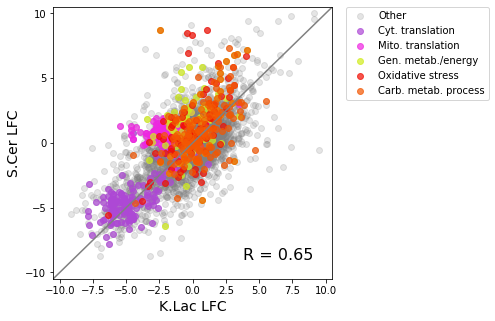

In [14]:
#Plot Go terms multiple colors on one axis

fig, ax = plt.subplots(figsize=(5,5))

#plot y=x line

xmin,xmax = (-10.5,10.5)
ymin,ymax = (-10.5,10.5)

ax.plot([xmin,xmax],[xmin,xmax], color = 'grey')

alpha = 0.7
go_term_subset = OrderedDict([('Cyt. translation', ('cytoplasmic translation','#ae48d6')),
                              ('Mito. translation', ('mitochondrial translation','#ef26e2')),
                              #('Conjugation', ('conjugation','#287ded')),
                              ('Gen. metab./energy', ('generation of precursor metabolites and energy','#d1ed1c')),
                              ('Oxidative stress', ('response to oxidative stress','#f20e02')),
                              ('Carb. metab. process', ('carbohydrate metabolic process','#f45702'))  #f1a501
                              #'Meiotic cell cycle': ('meiotic cell cycle','#0cebf7'),                      
                              #'rRNA processing': ('rRNA processing','#ae48d6')
                             ])
                  
subsets = OrderedDict({'Other': (kl_sc_PKA_data,
                              'gray',0.2)
                     })

for subset_name, (go_term, color) in go_term_subset.items(): 
    go_term_genes = go_slims_aspect[go_slims_aspect['GO_term']==go_term]['sc_genename']
    print('No data for ' + subset_name + ' for the following genes:')
    print(set(go_term_genes)-set(kl_sc_PKA_data.index))
    go_term_genes_present = list(set(kl_sc_PKA_data.index) & set(go_term_genes))
    subset_df = kl_sc_PKA_data.loc[go_term_genes_present,:]
    subsets[subset_name] = (subset_df, color, alpha )
    
for subset_name,(subset,color,alpha) in subsets.items():

    ax.scatter(subset['log2FoldChange_KL'], 
               subset['log2FoldChange_SC'],
               color = color, alpha = alpha, label = subset_name)

rval, pval = stats.pearsonr(kl_sc_PKA_data['log2FoldChange_SC'], kl_sc_PKA_data['log2FoldChange_KL'])


ax.text(3.8,-9,'R = {:.2f}'.format(rval),fontdict={'size':16})
ax.set_xlim([xmin,xmax])
ax.set_yticks([-10,-5,0,5,10])
ax.set_ylim([ymin,ymax])
ax.set_xlabel('K.Lac LFC',fontdict={'size':14})
ax.set_ylabel('S.Cer LFC',fontdict={'size':14})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#fig.savefig(os.path.normpath(figsave_dir + "SC_KL_LFC_goterms.svg"))  


No data for Cyt. translation for the following genes:
{'YGL189C', 'YFR032C-A', 'YOR312C', 'YDL133C-A', 'YMR242C', 'RDN5-5', 'RDN5-1', 'RDN18-1', 'YJL189W', 'YBR191W', 'RDN5-3', 'tS(UGA)P', 'RDN5-6', 'RDN5-2', 'YAL005C', 'YER017C', 'RDN58-1', 'RDN58-2', 'tS(UGA)E', 'tS(UGA)I', 'RDN5-4', 'RDN18-2', 'YDL184C', 'YLR367W'}
No data for Process Unknown for the following genes:
{'YJL152W', 'YCR087W', 'YNR042W', 'YHR212C', 'YMR247W-A', 'YJL202C', 'YLR157W-D', 'YDL196W', 'YHR021W-A', 'YLL044W', 'YOR318C', 'YDL011C', 'YMR082C', 'YLR154W-F', 'YML009W-B', 'YLR154W-E', 'YPL119C-A', 'YAL026C-A', 'YER078W-A', 'YGR160W', 'YHR180C-B', 'YHR213W', 'YNR005C', 'YKL162C-A', 'YFL015C', 'YDL228C', 'YLR428C', 'YOR376W', 'YAL066W', 'YNR077C', 'YGR226C', 'YNR071C', 'YIR036W-A', 'YDL086C-A', 'YKR033C', 'YOR385W', 'YJL020W-A', 'YDR053W', 'YBL073W', 'YHR218W', 'YDR102C', 'YOR055W', 'YMR272W-A', 'YIL014C-A', 'YLR364C-A', 'YPR013C', 'YER186C', 'YER066W', 'YIL029C', 'YIL025C', 'YGL006W-A', 'YOR331C', 'YNR066C', 'YIL060

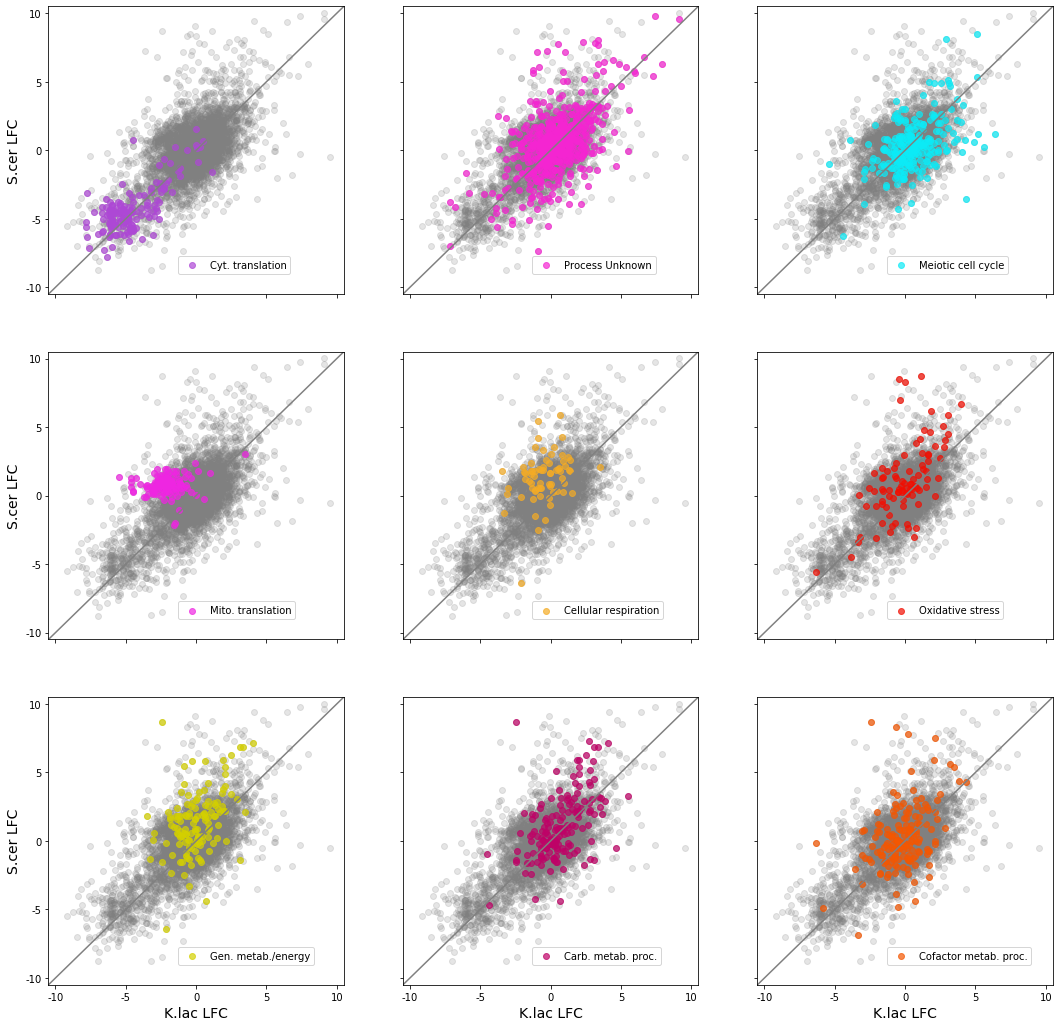

In [61]:
#Plot go terms on LFC Plot one go term per axis

fig, axarr = plt.subplots(3,3,figsize= (18,18))
#plot y=x line

xmin,xmax = (-10.5,10.5)
ymin,ymax = (-10.5,10.5)



alpha = 0.7
go_term_subset = OrderedDict([('Cyt. translation', ('cytoplasmic translation','#ae48d6')),
                              #('rRNA processing', ('rRNA processing','#7702bf')),
                              ('Process Unknown', ('biological_process','#f525d2')),
                              ('Meiotic cell cycle', ('meiotic cell cycle','#0cebf7')),
                              ('Mito. translation', ('mitochondrial translation','#ef26e2')),
                              ('Cellular respiration', ('cellular respiration','#f5ac25')),
                              ('Oxidative stress', ('response to oxidative stress','#f20e02')),
                              ('Gen. metab./energy', ('generation of precursor metabolites and energy','#d4d000')), #d1ed1c
                              ('Carb. metab. proc.', ('carbohydrate metabolic process','#bf0267')),  #f1a501 
                              ('Cofactor metab. proc.',('cofactor metabolic process','#f45702'))
                              #('AA metab. proc.', ('cellular amino acid metabolic process','#bf0267')),
                              #('Conjugation', ('conjugation','#287ded'))
                             ])
                  
bg_subset = kl_sc_PKA_data
bg_color = 'grey'
bg_alpha = 0.2

subsets = OrderedDict()

for subset_name, (go_term, color) in go_term_subset.items(): 
    go_term_genes = go_slims_aspect[go_slims_aspect['GO_term']==go_term]['sc_genename']
    print('No data for ' + subset_name + ' for the following genes:')
    print(set(go_term_genes)-set(kl_sc_PKA_data.index))
    go_term_genes_present = list(set(kl_sc_PKA_data.index) & set(go_term_genes))
    subset_df = kl_sc_PKA_data.loc[go_term_genes_present,:]
    #subset_df = kl_sc_PKA_data[kl_sc_PKA_data['sc_genename'].isin(go_term_genes)]
    subsets[subset_name] = (subset_df, color, alpha )
    
for jj, (subset_name,(subset,color,alpha)) in enumerate(subsets.items()):
    (row,col) = divmod(jj,3)
    ax = axarr[row,col]
    
    ax.scatter(bg_subset['log2FoldChange_KL'], 
               bg_subset['log2FoldChange_SC'],
               color = bg_color, alpha = bg_alpha, label = None)
                                              
    ax.scatter(subset['log2FoldChange_KL'], 
               subset['log2FoldChange_SC'],
               color = color, alpha = alpha, label = subset_name)
    
    ax.plot([xmin,xmax],[xmin,xmax], color = 'grey')

    # rval, pval = stats.pearsonr(kl_sc_PKA_data['log2FoldChange_SC'], kl_sc_PKA_data['log2FoldChange_KL'])
    # ax.text(3.8,-9,'R = {:.2f}'.format(rval),fontdict={'size':16})

    ax.set_xlim([xmin,xmax])
    ax.set_xticks([-10,-5,0,5,10])
    ax.set_yticks([-10,-5,0,5,10])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim([ymin,ymax])
    if row==2: 
        ax.set_xlabel('K.lac LFC',fontdict={'size':14})
        ax.set_xticklabels([-10,-5,0,5,10])
    if col==0:
        ax.set_ylabel('S.cer LFC',fontdict={'size':14})
        ax.set_yticklabels([-10,-5,0,5,10])
        
    ax.legend(bbox_to_anchor=(0.42,0.15)) #, loc=2, borderaxespad=0.)

fig.savefig(os.path.normpath(figsave_dir + "SC_KL_LFC_goterms_array.svg"))  


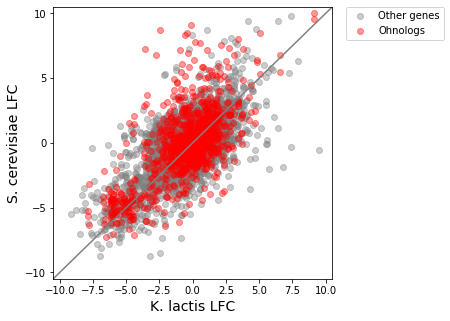

In [46]:
#Shade just orthologs

fig, ax = plt.subplots(figsize=(5,5))

xmin,xmax = (-10.5,10.5)
ymin,ymax = (-10.5,10.5)

alpha = 0.7  

ax.plot([xmin,xmax],[xmin,xmax], color = 'grey')

subsets = OrderedDict([('Other genes', (False,'gray',0.4)),
                       ('Ohnologs', (True,'red',0.4))
                      ])


for subset_name, (ohnolog_ind, color, alpha) in subsets.items(): 
    subset = kl_sc_PKA_data[kl_sc_PKA_data['ohnolog']==ohnolog_ind]    

    ax.scatter(subset['log2FoldChange_KL'], 
               subset['log2FoldChange_SC'],
               color = color, alpha = alpha, label = subset_name)

ax.set_xlim([-10.5,10.5])
ax.set_yticks([-10,-5,0,5,10])
ax.set_ylim([-10.5,10.5])
ax.set_xlabel('K. lactis LFC',fontdict={'size':14})
ax.set_ylabel('S. cerevisiae LFC',fontdict={'size':14})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#fig.savefig(os.path.normpath(figsave_dir + "SC_KL_LFC_paralogs_mpl.svg"))  


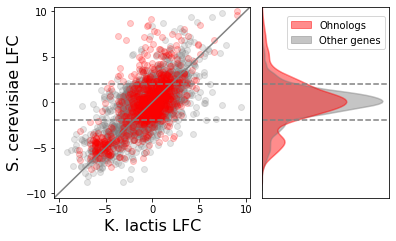

In [62]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
#grid = plt.GridSpec(5, 5, hspace=0.2, wspace=0.2)
grid = plt.GridSpec(5, 5, hspace=0.2, wspace=0.2)
ax_scatter = fig.add_subplot(grid[2:,0:-2])

xmin,xmax = (-10.5,10.5)
ymin,ymax = (-10.5,10.5)

#ax_xhist = fig.add_subplot(grid[0:2,0:-2 ], xticks=[],yticks=[]) #, sharey=ax_scatter)
ax_yhist = fig.add_subplot(grid[2:,-2:], xticks=[],yticks=[]) #, sharex=ax_scatter)

#(N_paralogs, color, alpha, alpha_kde)
subsets = OrderedDict([('Other Genes', (False,'gray',0.2, 0.45)),
                       ('Ohnologs', (True,'red',0.2, 0.45))
                      ])


for subset_name, (ohnolog_ind, color, alpha, alpha_kde) in subsets.items(): 
    subset = kl_sc_PKA_data[kl_sc_PKA_data['ohnolog']==ohnolog_ind]    
    
    ax_scatter.scatter(subset['log2FoldChange_KL'], subset['log2FoldChange_SC'], color=color, alpha=alpha)
#     sns.distplot(subset['log2FoldChange_KL'], hist=False, rug=False, ax=ax_xhist, 
#                  kde_kws={"color": color, "shade":True,  "label": subset_name, "alpha": alpha_kde}) #"lw": 2,
    sns.distplot(subset['log2FoldChange_SC'], hist=False, rug=False, ax=ax_yhist, 
                 kde_kws={"color": color, "shade":True, "label": subset_name, "alpha":alpha_kde}, vertical=True) #"lw": 2, 
    #ax_yhist.invert_xaxis()
#sns.jointplot(x = subset['log2FoldChange_KL'] , y = subset['log2FoldChange_SC'], kind='kde', color = color, ax = ax)
#     sns.distplot(subset['log2FoldChange_SC'], hist=False, rug=False, ax=ax, 
#                  kde_kws={"color": color, "shade":True, "lw": 2, "label": subset_name})
  
    
ax_scatter.set_xlim([xmin, xmax])
ax_scatter.set_ylim([ymin, ymax])
ax_yhist.set_ylim([ymin, ymax])
#ax_xhist.set_xlim([xmin, xmax])


ax_scatter.set_xlabel('K. lactis LFC',fontdict={'size':16})
ax_scatter.set_ylabel('S. cerevisiae LFC',fontdict={'size':16})

lfc_thresh_act = 2.0
lfc_thresh_rep = -2.0
ax_scatter.plot([xmin,xmax],[ymin,ymax], color = 'grey')
ax_scatter.plot([xmin,xmax],[lfc_thresh_act,lfc_thresh_act], color = 'grey', linestyle = 'dashed')
ax_scatter.plot([xmin,xmax],[lfc_thresh_rep,lfc_thresh_rep], color = 'grey', linestyle = 'dashed')
ax_scatter.set_xticks([-10,-5,0,5,10])
ax_scatter.set_yticks([-10,-5,0,5,10])

legend_elements = [#Line2D([0], [0], color='b', lw=4, label='Line'),
                   #Line2D([0], [0], marker='o', color='w', label='Scatter',
                   #       markerfacecolor='g', markersize=15),
                   Patch(facecolor='red', alpha =0.45,  edgecolor='red',
                         label='Ohnologs'), 
                   Patch(facecolor='grey', alpha = 0.45, edgecolor='grey',
                         label='Other genes') 
#                    Patch(facecolor=act_rep_color, edgecolor=act_rep_color,
#                          label='One ohnolog activated, one ohnolog repressed'), 
#                    Patch(facecolor=no_eff_color, edgecolor=no_eff_color,
#                          label='Not effected by PKA inhibition'), 
#                    Patch(fill=False, edgecolor= 'grey', hatch = '///',
#                          label='$DE_{PKA}$') 
                    ]

#ax.legend(bbox_to_anchor=(1.05,1.0))
ax_yhist.legend(handles=legend_elements, bbox_to_anchor=(0.2, 0.95), loc=2, borderaxespad= 0.) #, loc='center')


#ax_yhist.legend(bbox_to_anchor=(0.0, 1.3), loc=2, borderaxespad=0.)
#kl_legend = ax_xhist.legend()
#kl_legend.remove()
#ax_xhist.set_xlabel('')
ax_yhist.set_ylabel('')

(xmin_yhist,xmax_yhist) = ax_yhist.get_xlim()
ax_yhist.plot([xmin_yhist,xmax_yhist],[lfc_thresh_act,lfc_thresh_act], color = 'grey', linestyle = 'dashed')
ax_yhist.plot([xmin_yhist,xmax_yhist],[lfc_thresh_rep,lfc_thresh_rep], color = 'grey', linestyle = 'dashed')
ax_yhist.set_xlim(xmin_yhist,xmax_yhist)  #if you don't do this it adds on margins

#ax.set_xlabel('S.Cer LFC')

fig.savefig(os.path.normpath(figsave_dir + "SC_KL_LFC_paralogs_margdists.svg"))  


    

In [53]:
#Plot LFC for SC and KL on the same axis



data = []

xlabel = 'LFC: K.lac AS -/+ 3uM 1-NM-PP1'
ylabel = 'LFC: S.Cer AS -/+ 3uM 1-NM-PP1'

wgh_n_orthologs = {'Other genes':False, 'Ohnologs':True}
wgh_color = {'Ohnologs':'red', 'Other genes':'gray'}

# #Calculate R for all the data
# rval, pval = stats.pearsonr(kl_sc_PKA_data['log2FoldChange_SC'], kl_sc_PKA_data['log2FoldChange_KL'])

for geneset in ['Other genes', 'Ohnologs']:
    
    kl_sc_PKA_data_subset = kl_sc_PKA_data[kl_sc_PKA_data['ohnolog']==wgh_n_orthologs[geneset]]
    
    trace = pygo.Scatter(
                x = kl_sc_PKA_data_subset['log2FoldChange_KL'], 
                y =  kl_sc_PKA_data_subset['log2FoldChange_SC'],
                text = kl_sc_PKA_data_subset['SC_common_name'],
                mode = 'markers',
                marker = {'opacity': 0.4,  
                          'color': wgh_color[geneset],
                          'size': 10}, 
                name = geneset
            )

    data.append(trace)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": xlabel
    },
    yaxis= {
        #"range":[-10, 10],
        "title": ylabel
    }, 
    height = 600,
    width = 640,
    annotations=[
        dict(
            x=-7.0,
            y=7.0,
#             xref='x',
#             yref='y',
            text='<b>R = {:.2f}</b>'.format(rval),
            showarrow=False 
            #fontsize = 14
#            arrowhead=7,
#            ax=0,
#            ay=-40
        )
    ]
)


fig = pygo.Figure(data=data, layout = layout)
fig
#py.iplot(fig, filename= 'AS_pmNMPP1_kl_v_sc')

#pio.write_image(fig, os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/LFC_compare.svg'))


Figure [x]: : We collected RNA Sequencing data after inhibiting PKA in S.Cer and K.Lac PKA(AS) mutants growing in YPD containing 3uM 1-NMPP1 after 50min.  Estimated log2 fold change (LFC) values using DESEQ2 [3] are shown for all orthologous genes.  Red shading indicates a gene that has a WGH paralog in S.Cer.  

In [27]:
kl_sc_PKA_data.loc[kl_sc_PKA_data['SC_common_name']=='YCL048W-A',:]

N SCer Orthologs   kl_genename sc_genename  baseMean_KL  \
4463                 2  KLLA0C00957g   YCL048W-A  1335.975339   

      log2FoldChange_KL  lfcSE_KL   stat_KL  pvalue_KL   padj_KL  baseMean_SC  \
4463          -0.932691  0.309348 -3.015022    0.00257  0.006442    11.836791   

      log2FoldChange_SC  lfcSE_SC   stat_SC     pvalue_SC       padj_SC  \
4463           7.098852   1.35298  5.246827  1.547408e-07  7.747821e-07   

     SC_common_name  
4463      YCL048W-A

## Calculate enrichment for ohnologs in the various activation sets. 

In [108]:
#Enrichment for ohnologs

#Load PKA activation sets and combinations from both species
gene_sets, background_map, background_genes = yeast_esr_exp.build_pka_act_rep_target_sets()

#Load Ohnolog data
ohnologs = pd.read_csv(data_processing_dir + os.path.normpath("ortholog_files_YGOB/ohnologs.csv"), index_col=0)
print('Total number of Ohnologs: ' + str(len(ohnologs)))

all_ohnologs = set(list(ohnologs['Gene 1']) + list(ohnologs['Gene 2']))



output = {}
#output_order = (N subset genes ohnologs, p-value, pct ohnologs in subset, pct ohnologs in background, pct of all ohnologs)
gene_set_names = [ 'sc_act', 'sc_rep', 'sc_no_change','kl_only_act', 'kl_only_rep', 'sc_only_act', 'sc_only_rep', 'klsc_act', 'klsc_rep']

for gene_set_name in gene_set_names: 
    gene_set = gene_sets[gene_set_name] 
    background_set = background_genes[background_map[gene_set_name]]
    
    N_subset_genes_ohnologs = len(gene_set & all_ohnologs)
    N_subset_genes_not_ohnologs = len(gene_set)-N_subset_genes_ohnologs
    N_bg_genes_ohnologs = len(background_set & all_ohnologs)
    N_bg_genes_not_ohnologs = len(background_set)-N_bg_genes_ohnologs
    
    oddsratio, pvalue = stats.fisher_exact([[N_subset_genes_ohnologs, N_bg_genes_ohnologs], [N_subset_genes_not_ohnologs, N_bg_genes_not_ohnologs]],alternative = 'greater')
    
    output[gene_set_name] = (N_subset_genes_ohnologs, 
                             pvalue, 
                             N_subset_genes_ohnologs/(len(gene_set)), 
                             N_bg_genes_ohnologs/(len(background_set)), 
                             N_subset_genes_ohnologs/N_bg_genes_ohnologs)

ohnolog_enrichment = pd.DataFrame.from_dict(output, orient='index', 
                       columns = ["N subset genes that are ohnologs", 
                                  "P-value", 
                                  "pct ohnologs in subset", 
                                  "pct ohnologs in background", 
                                  "pct of all ohnologs from subset"]
                      )

FDR = 0.05
(result,padj,_,_) = sm.stats.multipletests(ohnolog_enrichment['P-value'],alpha=FDR, method = 'fdr_bh')

ohnolog_enrichment['padj'] = padj
ohnolog_enrichment['detect_FDR'] = result

fname = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/ohnolog_enrichment_20200611.csv") 
#fname = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/ohnolog_enrichment_20190814.csv")
ohnolog_enrichment.to_csv(fname)

In [18]:
# #Load PKA targets for both species (from go_enrichment script)
# fname = data_processing_dir + '\\kl_sc_PKA_as_m24_r1g1_20181017\\20181204_klsc_pkainh_subsets_for_enrichment.pkl'

# with open(fname, 'rb') as file:
#     [gene_sets, background_genes, background_map] = pickle.load(file)
  


In [28]:
# for gene_set_name, gene_set in gene_sets.items(): 
#     print(gene_set_name)
#     subset_genes = kl_sc_PKA_data[kl_sc_PKA_data['sc_genename'].isin(gene_set)]
#     subset_genes_w_paralog = subset_genes[subset_genes['N SCer Orthologs']==2]

#     N_subset_genes = len(subset_genes)
#     N_subset_genes_w_paralog = len(subset_genes_w_paralog)
#     N_subset_genes_no_paralog = N_subset_genes - N_subset_genes_w_paralog


#     N_bg_genes = len(kl_sc_PKA_data)
#     bg_genes_w_paralog = kl_sc_PKA_data[kl_sc_PKA_data['N SCer Orthologs'] == 2]
#     N_bg_genes_w_paralog = len(bg_genes_w_paralog)
#     N_bg_genes_no_paralog = N_bg_genes - len(bg_genes_w_paralog)



#     oddsratio, pvalue = stats.fisher_exact([[N_subset_genes_w_paralog, N_bg_genes_w_paralog], [N_subset_genes_no_paralog, N_bg_genes_no_paralog]],alternative = 'greater')
#     print(oddsratio)
#     print(pvalue)

Older statement: 
Statement[paralog_enrichment] In the group of genes that were activated by S.Cerevisiae only, ohnologs were enriched (pvalue=1.02e-15, Fisher's exact test) and they were not enriched in the genes that were activated only in K.Lactis (pvalue = 0.55) or in both species (pvalue = 0.34).   Paralogs were enriched in genes that were repressed in both species as well (pvalue = 1.42e-4) but not in genes repressed under pka inhibition in a species specific manner (pvalue = 0.83, 0.38 for K.Lac and S.Cer respectively) 

## Count numbers of activated / repressed genes

In [178]:
target_sets_dict = {}
for spec in ['KL', 'SC']: 
    fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/20181203_r1g1_m24_pka_targets_' + spec + '.pkl')
    
    with open(fname, 'rb') as file:
        target_sets_dict[spec] = pickle.load(file)

In [3]:
fname_cross_spec_comparison = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/cross_species_compare_ASminus_ASplus_YPD_20181204.csv")
kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)

In [48]:
kl_sc_PKA_data.columns

Index(['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
       'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL',
       'baseMean_SC', 'log2FoldChange_SC', 'lfcSE_SC', 'stat_SC', 'pvalue_SC',
       'padj_SC', 'SC_common_name'],
      dtype='object')

In [54]:
print("Total number of annotated genes from length of rows in 2018_countdata_SC/KL.")
print("SC: 6601")
print("KL: 5535")
for spec in ['SC','KL']:
    for target_set_name in ['pkainh_act', 'pkainh_rep']: 
        print("Species: {}.  Total number of genes in {}:  {}".format(spec, target_set_name, str(len(target_sets_dict[spec][0][target_set_name]))))
    
print("Total number of genes with orthologs in both species " + str(len(kl_sc_PKA_data)))
for spec in ['SC','KL']:
    for target_set_name in ['pkainh_act', 'pkainh_rep']: 
        target_set = target_sets_dict[spec][0][target_set_name]
        target_set_sc_kl = target_set & set(kl_sc_PKA_data[spec.lower() + '_genename'])
        print("Species: {}.  Total number of genes in {}:  {}".format(spec, target_set_name, str(len(target_set_sc_kl))))



Total number of annotated genes from length of rows in 2018_countdata_SC/KL.
SC: 6601
KL: 5535
Species: SC.  Total number of genes in pkainh_act:  509
Species: SC.  Total number of genes in pkainh_rep:  697
Species: KL.  Total number of genes in pkainh_act:  426
Species: KL.  Total number of genes in pkainh_rep:  660
Total number of genes with orthologs in both species 4793
Species: SC.  Total number of genes in pkainh_act:  397
Species: SC.  Total number of genes in pkainh_rep:  640
Species: KL.  Total number of genes in pkainh_act:  290
Species: KL.  Total number of genes in pkainh_rep:  599


In [169]:
#Count number of orthologs activated and repressed
#Load GOI ohnolog data

fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_20190814.pkl')

with open(fname, 'rb') as file:
    [ohnologs_goi,ohnologs_expression_sorted,goi_criteria] = pickle.load(file)

#Merge with kl_orthologs set
#Load KL ortholog data
kl_orthologs = pd.read_pickle(data_processing_dir + "ortholog_files_YGOB/kl_orthologs.pkl")
ohnologs_expression_sorted_klorth = ohnologs_expression_sorted.merge(kl_orthologs, how='inner', left_on='sc_genename_low',right_on='sc_genename')

#merege in KL LFC Data
lfc_data_KL = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20181017_deseq_KL_AS_WT_nmpp1.csv'), index_col=0)
kl_genenames = yeast_esr_exp.kl_genename_convert_list(lfc_data_KL.index)
lfc_data_KL['kl_genename'] = kl_genenames
lfc_data_KL.set_index('kl_genename',inplace = True)
lfc_data_KL.index.name = spec.lower() + "_genename"
lfc_data_KL.rename(columns={column:column+'_KL' for column in lfc_data_KL.columns}, inplace=True)

ohnologs_expression_sorted_klorth = ohnologs_expression_sorted_klorth.merge(lfc_data_KL,left_on='kl_genename',right_index=True,  how='inner')

In [33]:
#Counts of activated and repressed ohnologs in comparison with KL using initial Activation/Repression thresholds.

#using loaded target sets
for act_rep, level, opp_level in [('act','high','low'),('rep','low','high')]:
    all_targets_SC = target_sets_dict['SC'][0]['pkainh_' + act_rep]
    all_targets_KL = target_sets_dict['KL'][0]['pkainh_' + act_rep]
    target_ohnologs = ohnologs_expression_sorted_klorth[ohnologs_expression_sorted_klorth['sc_genename_'+level].isin(all_targets_SC)]
    target_ohnologs_similar_exp = target_ohnologs[target_ohnologs['sc_genename_' + opp_level].isin(all_targets_SC)]
    target_ohnologs_KL = target_ohnologs[target_ohnologs['kl_genename'].isin(all_targets_KL)]
    print(("{} total ohnologs pairs with at least one gene {} by PKA inhibition. \n" + 
          "{} ohnolog pairs with both genes {} by PKA inhibition. \n" + 
          "{} ohnolog pairs with KL ortholog also {} by PKA inhibition").format(len(target_ohnologs),
                                                                       act_rep, 
                                                                       len(target_ohnologs_similar_exp), 
                                                                       act_rep, 
                                                                       len(target_ohnologs_KL),
                                                                       act_rep)
         )


#target_sets_dict['SC'][0]['pkainh_rep']

120 total ohnologs pairs with at least one gene act by PKA inhibition. 
20 ohnolog pairs with both genes act by PKA inhibition. 
23 ohnolog pairs with KL ortholog also act by PKA inhibition
114 total ohnologs pairs with at least one gene rep by PKA inhibition. 
56 ohnolog pairs with both genes rep by PKA inhibition. 
70 ohnolog pairs with KL ortholog also rep by PKA inhibition


In [170]:
#Counts of activated and repressed ohnologs in comparison with KL using DEpka activation/repression thresholds. 

#thresholds: LFC, pvalue
threshs = {'act': (2.0,1.0,-1.5,'high'), 'rep': (-2.0,-1.0,-1.5,'low')}

one_ohnolog = {}
one_ohnolog_pval= {}
one_ohnolog_klorth = {}
one_ohnolog_klorth_pval = {}

for act_rep in ['act','rep']: 
    (thresh,mult, pval_thresh , level) = threshs[act_rep]
    one_ohnolog[act_rep] = ohnologs_expression_sorted_klorth[(mult*ohnologs_expression_sorted_klorth['log2FoldChange_' + level])>(mult*thresh)]
    print("Total Ohnolog pairs w/ at least one {}: {}".format(act_rep,len(one_ohnolog[act_rep])))
    one_ohnolog_pval[act_rep] = one_ohnolog[act_rep][np.log10(one_ohnolog[act_rep]['pvalue_'+level])<pval_thresh]
    print("Total Ohnolog pairs w/ at least one {}, and pval thresh met: {}".format(act_rep,len(one_ohnolog_pval[act_rep])))
    one_ohnolog_klorth[act_rep] = one_ohnolog_pval[act_rep][(mult*one_ohnolog_pval[act_rep]['log2FoldChange_KL'])>(mult*thresh)]
    one_ohnolog_klorth_pval[act_rep] = one_ohnolog_klorth[act_rep][np.log10(one_ohnolog_klorth[act_rep]['pvalue_KL'])<pval_thresh]
    print("Total Ohnolog pairs w/ at least one {}, and kl orth also {}, (pval thresh met): {}".format(act_rep,act_rep, len(one_ohnolog_klorth_pval[act_rep])))
    #     both_ohnologs[level] = one_ohnolog[level][(mult*one_ohnolog[level]['log2FoldChange_'+ opposite])>(mult*thresh)]
#     print("Total Ohnolog pairs w/ both {}: {}".format(level,len(both_ohnologs[level])))
#     both_ohnologs_pval1 = one_ohnolog_pval[level][(mult*one_ohnolog_pval[level]['log2FoldChange_'+ opposite])>(mult*thresh)]
#     both_ohnologs_pval[level] = both_ohnologs_pval1[np.log10(both_ohnologs_pval1['pvalue_'+opposite])<pval_thresh]
#     print("Total Ohnolog pairs w/ both {}: {}, and pval thresh met".format(level,len(both_ohnologs_pval[level])))

#get ohnolog data for S.Cer and K.Lac

#ohnologs_expression_sorted_klorth



Total Ohnolog pairs w/ at least one act: 142
Total Ohnolog pairs w/ at least one act, and pval thresh met: 138
Total Ohnolog pairs w/ at least one act, and kl orth also act, (pval thresh met): 28
Total Ohnolog pairs w/ at least one rep: 128
Total Ohnolog pairs w/ at least one rep, and pval thresh met: 122
Total Ohnolog pairs w/ at least one rep, and kl orth also rep, (pval thresh met): 77


In [69]:
one_ohnolog_pval[act_rep]['log2FoldChange_KL']

Ancestor AA %id  Length Ratio sc_genename_low SC_common_name_low  \
0     Anc_1.15    25%          0.73         YDR528W               HLR1   
2     Anc_1.22    48%          0.84       YDR524C-B          YDR524C-B   
4     Anc_1.36    25%          0.97         YCL037C               SRO9   
5     Anc_1.37    37%          0.85         YCL036W               GFD2   
7     Anc_1.50    67%          0.95         YDR508C               GNP1   
9     Anc_1.58    91%          0.99         YLR180W               SAM1   
11    Anc_1.62    93%          1.00         YLR185W             RPL37A   
15   Anc_1.136    69%          0.95         YJL198W              PHO90   
16   Anc_1.140    55%          0.89         YCR034W               FEN1   
17   Anc_1.146    97%          0.99         YJL191W             RPS14B   
18   Anc_1.157    23%          0.82         YJR030C            YJR030C   
19   Anc_1.161    98%          1.00         YJL177W             RPL17B   
25   Anc_1.211   100%          1.00         YJL138C               TIF2   
27   Anc_1.213    98%          1.00         YJL136C             RPS21B   
38   Anc_1.291    51%          0.91         YKR013W               PRY2   
51   Anc_1.391    83%          1.00         YLR249W               YEF3   
55   Anc_1.422    78%          0.96         YCR005C               CIT2   
62   Anc_1.482    83%          0.96         YJR048W               CYC1   
70    Anc_2.41    99%          1.00         YDL229W               SSB1   
77    Anc_2.95   100%          1.00         YHR141C             RPL42B   
85   Anc_2.172    82%          0.98         YOR108W               LEU9   
89   Anc_2.202    54%          0.99         YNL087W               TCB2   
92   Anc_2.228    89%          0.99         YNL069C             RPL16B   
95   Anc_2.242    35%          0.96         YNL065W               AQR1   
106  Anc_2.386   100%          1.00         YDL083C             RPS16B   
107  Anc_2.387    98%          1.00         YMR142C             RPL13B   
110  Anc_2.417    99%          1.00         YLR029C             RPL15A   
111  Anc_2.418    85%          1.00         YMR120C              ADE17   
123  Anc_2.505    99%          1.00         YKL006W             RPL14A   
139   Anc_3.51    99%          1.00         YNL302C             RPS19B   
..         ...    ...           ...             ...                ...   
348  Anc_6.317    47%          0.95         YNR019W               ARE2   
357    Anc_7.1    87%          0.99         YOR375C               GDH1   
362   Anc_7.48    17%          0.84         YOR342C            YOR342C   
373  Anc_7.187   100%          1.00         YIL018W              RPL2B   
376  Anc_7.237    98%          1.00         YIL052C             RPL34B   
379  Anc_7.243    92%          1.00         YIL053W               RHR2   
380  Anc_7.246    32%          0.79         YER064C               VHR2   
382  Anc_7.256    81%          0.98         YER070W               RNR1   
383  Anc_7.262   100%          1.00         YIL069C             RPS24B   
385  Anc_7.281    44%          0.96         YIL079C               AIR1   
391  Anc_7.306   100%          1.00         YDL136W             RPL35B   
397  Anc_7.372    29%          0.78         YBL054W               TOD6   
402  Anc_7.391    89%          0.97         YBL068W               PRS4   
403  Anc_7.395   100%          1.00         YER102W              RPS8B   
407  Anc_7.417   100%          1.00         YBL087C             RPL23A   
413  Anc_7.466   100%          1.00         YPR043W             RPL43A   
414  Anc_7.476    78%          0.97         YBL039C               URA7   
421   Anc_8.31    81%          0.99         YLR061W             RPL22A   
425  Anc_8.109    32%          0.90         YPR009W               SUT2   
435  Anc_8.254    74%          0.99         YLR083C              EMP70   
440  Anc_8.318    50%          0.95         YDR144C               MKC7   
449  Anc_8.432    50%          0.98         YDR222W            YDR222W   
460  Anc_8

In [56]:
lfc_data_KL.rename(columns={column:column+'_KL' for column in lfc_data_KL.columns})

baseMean_KL  log2FoldChange_KL  lfcSE_KL    stat_KL  \
sc_genename                                                            
KLLA0F07865g     1860.450107          -6.712656  0.310417 -21.624636   
KLLA0F16511g     4849.903416          -6.177243  0.293051 -21.079096   
KLLA0F09812g     2581.969140          -6.319922  0.318801 -19.824056   
KLLA0E00573g     5348.644521          -6.152352  0.312008 -19.718561   
KLLA0C18216g     2480.029881          -7.287174  0.372553 -19.560083   
KLLA0F25542g    10248.922072          -6.303665  0.323422 -19.490542   
KLLA0F04675g     4944.507613          -5.946767  0.305608 -19.458795   
KLLA0B08173g     1027.791128          -6.155644  0.330752 -18.611074   
KLLA0D07832g     5590.744808          -6.114816  0.329786 -18.541793   
KLLA0B05742g     5100.110587          -5.858720  0.316612 -18.504397   
KLLA0E24135g     1042.742753          -6.847673  0.378231 -18.104487   
KLLA0F05247g     1601.879954          -5.371840  0.296672 -18.106991   
KLLA0E10847g     3924.210179          -6.978251  0.390281 -17.880071   
KLLA0B05918g     4359.554739          -6.153357  0.346581 -17.754478   
KLLA0F08657g     2117.096516          -6.174685  0.348696 -17.707936   
KLLA0D07405g     3086.206906          -4.734113  0.267879 -17.672575   
KLLA0B05060g     7631.655903          -4.625663  0.263145 -17.578363   
KLLA0C11209g      750.195044           6.161097  0.353828  17.412684   
KLLA0F22341g      690.300193           7.755364  0.446714  17.360918   
KLLA0C08371g     4290.984553          -5.006492  0.289726 -17.280118   
KLLA0F23243g      855.722996          -5.799119  0.335612 -17.279252   
KLLA0D05907g      955.627360           7.342179  0.425635  17.249931   
KLLA0E07481g     2319.000780          -4.740126  0.277477 -17.082973   
KLLA0B04664g     1308.281088          -5.429855  0.318442 -17.051298   
KLLA0E16171g     1047.162814          -6.597291  0.387060 -17.044601   
KLLA0E12453g     2827.685885          -5.175306  0.310384 -16.673887   
KLLA0B07623g     4919.984470          -6.069428  0.364079 -16.670618   
KLLA0E23673g     2148.367756          -6.108792  0.368360 -16.583748   
KLLA0C13519g     1127.738891          -5.967476  0.360649 -16.546486   
KLLA0F19382g      685.528526           6.588572  0.403894  16.312636   
...                      ...                ...       ...        ...   
KLLA0F06314g       93.819000          -0.007653  0.424022  -0.018048   
KLLA0C16577g      132.083907           0.005012  0.302042   0.016593   
KLLA0F24981g       64.938999          -0.005483  0.348519  -0.015732   
KLLA0E06711g      131.516605           0.004746  0.317066   0.014969   
KLLA0E15819g       25.689868           0.006468  0.446650   0.014481   
KLLA0B00759g      142.570999          -0.004709  0.348226  -0.013524   
KLLA0F04840g      129.143354           0.004714  0.352469   0.013373   
KLLA0C02563g      300.885768           0.003848  0.309052   0.012453   
KLLA0F23826g       30.000182           0.005665  0.461389   0.012279   
KLLA0B03850g      165.675555           0.003586  0.315697   0.011361   
KLLA0F27159g       62.522887           0.004481  0.392915   0.011405   
KLLA0D16753g       10.200795           0.006390  0.647571   0.009867   
KLLA0E11309g        6.914616          -0.006895  0.741773  -0.009296   
KLLA0C02497g      180.508911          -0.002226  0.317622  -0.007009   
KLLA0C10593g      159.011534           0.002108  0.367439   0.005736   
KLLA0F05093g      327.353594           0.001894  0.348712   0.005432   
EBG00000981844      0.297584          -0.010314  3.323152  -0.003104   
KLLA0A08965r        0.356949           0.009892  3.122660   0.003168   
KLLA0B03333g        0.297584          -0.010314  3.323152  -0.003104   
KLLA0B12518g        0.408115           0.012811  2.998535   0.004272   
KLLA0C01386g       73.722504          -0.001521  0.379987  -0.004002   
KLLA0F08063g      226.197257          -0.001382  0.337068  -0.004101   
KLLA0F10615g      402.471233          -0.000900  0.280866

In [42]:
len(ohnologs_expression_sorted_klorth)

491

In [58]:
ohnologs_expression_sorted_klorth.merge(lfc_data_KL,left_on='kl_genename',right_index=True,  how='inner')

Ancestor AA %id  Length Ratio sc_genename_low SC_common_name_low  \
0     Anc_1.15    25%          0.73         YDR528W               HLR1   
1     Anc_1.17    60%          0.99         YCL050C               APA1   
2     Anc_1.22    48%          0.84       YDR524C-B          YDR524C-B   
3     Anc_1.25    42%          0.92         YDR522C               SPS2   
4     Anc_1.36    25%          0.97         YCL037C               SRO9   
5     Anc_1.37    37%          0.85         YCL036W               GFD2   
6     Anc_1.38    62%          0.77         YDR513W               GRX2   
7     Anc_1.50    67%          0.95         YDR508C               GNP1   
8     Anc_1.52    47%          0.91         YDR507C               GIN4   
9     Anc_1.58    91%          0.99         YLR180W               SAM1   
10    Anc_1.61    31%          0.94         YLR183C               TOS4   
11    Anc_1.62    93%          1.00         YLR185W             RPL37A   
12    Anc_1.66    32%          0.97         YLR187W               SKG3   
13    Anc_1.83    65%          0.97         YEL063C               CAN1   
14   Anc_1.100    37%          1.00         YHR155W               YSP1   
15   Anc_1.136    69%          0.95         YJL198W              PHO90   
16   Anc_1.140    55%          0.89         YCR034W               FEN1   
17   Anc_1.146    97%          0.99         YJL191W             RPS14B   
18   Anc_1.157    23%          0.82         YJR030C            YJR030C   
19   Anc_1.161    98%          1.00         YJL177W             RPL17B   
20   Anc_1.180    39%          0.85         YJL165C               HAL5   
21   Anc_1.182    71%          1.00         YKL166C               TPK3   
22   Anc_1.187    55%          0.84         YKL164C               PIR1   
23   Anc_1.188    74%          0.79         YJL159W             HSP150   
24   Anc_1.209    60%          0.99         YKR061W               KTR2   
25   Anc_1.211   100%          1.00         YJL138C               TIF2   
26   Anc_1.212    44%          0.62         YJL137C               GLG2   
27   Anc_1.213    98%          1.00         YJL136C             RPS21B   
29   Anc_1.219    72%          0.97         YJL133W               MRS3   
30   Anc_1.224    51%          0.72         YJL129C               TRK1   
..         ...    ...           ...             ...                ...   
459  Anc_8.546    22%          0.90         YPL077C            YPL077C   
460  Anc_8.554    96%          0.99         YBR189W              RPS9B   
461  Anc_8.564    52%          1.00         YPL087W               YDC1   
462  Anc_8.566    28%          0.67         YBR182C               SMP1   
463  Anc_8.567   100%          1.00         YPL090C              RPS6A   
464  Anc_8.574    58%          0.99         YPL095C               EEB1   
465  Anc_8.587    29%          0.87         YBR172C               SMY2   
466  Anc_8.590    75%          1.00         YPL106C               SSE1   
467  Anc_8.601    18%          0.95         YPL112C              PEX25   
468  Anc_8.644    62%          0.99         YOR222W               ODC2   
469  Anc_8.647    70%          0.95         YOR226C               ISU2   
470  Anc_8.648    44%          0.98         YPL137C               GIP3   
471  Anc_8.651    37%          0.99         YOR229W               WTM2   
472  Anc_8.652    57%          1.00         YOR231W               MKK1   
473  Anc_8.654    41%          0.92         YOR233W               KIN4   
474  Anc_8.655    99%          1.00         YPL143W             RPL33A   
475  Anc_8.658    69%          1.00         YPL145C               KES1   
476  Anc_8.702    44%          0.97         YOR256C               TRE2   
477  Anc_8.760    97%          1.00         YOR293W             RPS10A   
478  Anc_8.764    37%          0.99         YOR295W              UAF30   
479  Anc_8.772    56%          0.97         YOR299W               BUD7   
481  Anc_8.796    61%          0.99         YMR246W               FAA4   
483  Anc_8

In [171]:
lfc_data_KL

baseMean_KL  log2FoldChange_KL  lfcSE_KL    stat_KL  \
sc_genename                                                            
KLLA0F07865g     1860.450107          -6.712656  0.310417 -21.624636   
KLLA0F16511g     4849.903416          -6.177243  0.293051 -21.079096   
KLLA0F09812g     2581.969140          -6.319922  0.318801 -19.824056   
KLLA0E00573g     5348.644521          -6.152352  0.312008 -19.718561   
KLLA0C18216g     2480.029881          -7.287174  0.372553 -19.560083   
KLLA0F25542g    10248.922072          -6.303665  0.323422 -19.490542   
KLLA0F04675g     4944.507613          -5.946767  0.305608 -19.458795   
KLLA0B08173g     1027.791128          -6.155644  0.330752 -18.611074   
KLLA0D07832g     5590.744808          -6.114816  0.329786 -18.541793   
KLLA0B05742g     5100.110587          -5.858720  0.316612 -18.504397   
KLLA0E24135g     1042.742753          -6.847673  0.378231 -18.104487   
KLLA0F05247g     1601.879954          -5.371840  0.296672 -18.106991   
KLLA0E10847g     3924.210179          -6.978251  0.390281 -17.880071   
KLLA0B05918g     4359.554739          -6.153357  0.346581 -17.754478   
KLLA0F08657g     2117.096516          -6.174685  0.348696 -17.707936   
KLLA0D07405g     3086.206906          -4.734113  0.267879 -17.672575   
KLLA0B05060g     7631.655903          -4.625663  0.263145 -17.578363   
KLLA0C11209g      750.195044           6.161097  0.353828  17.412684   
KLLA0F22341g      690.300193           7.755364  0.446714  17.360918   
KLLA0C08371g     4290.984553          -5.006492  0.289726 -17.280118   
KLLA0F23243g      855.722996          -5.799119  0.335612 -17.279252   
KLLA0D05907g      955.627360           7.342179  0.425635  17.249931   
KLLA0E07481g     2319.000780          -4.740126  0.277477 -17.082973   
KLLA0B04664g     1308.281088          -5.429855  0.318442 -17.051298   
KLLA0E16171g     1047.162814          -6.597291  0.387060 -17.044601   
KLLA0E12453g     2827.685885          -5.175306  0.310384 -16.673887   
KLLA0B07623g     4919.984470          -6.069428  0.364079 -16.670618   
KLLA0E23673g     2148.367756          -6.108792  0.368360 -16.583748   
KLLA0C13519g     1127.738891          -5.967476  0.360649 -16.546486   
KLLA0F19382g      685.528526           6.588572  0.403894  16.312636   
...                      ...                ...       ...        ...   
KLLA0F06314g       93.819000          -0.007653  0.424022  -0.018048   
KLLA0C16577g      132.083907           0.005012  0.302042   0.016593   
KLLA0F24981g       64.938999          -0.005483  0.348519  -0.015732   
KLLA0E06711g      131.516605           0.004746  0.317066   0.014969   
KLLA0E15819g       25.689868           0.006468  0.446650   0.014481   
KLLA0B00759g      142.570999          -0.004709  0.348226  -0.013524   
KLLA0F04840g      129.143354           0.004714  0.352469   0.013373   
KLLA0C02563g      300.885768           0.003848  0.309052   0.012453   
KLLA0F23826g       30.000182           0.005665  0.461389   0.012279   
KLLA0B03850g      165.675555           0.003586  0.315697   0.011361   
KLLA0F27159g       62.522887           0.004481  0.392915   0.011405   
KLLA0D16753g       10.200795           0.006390  0.647571   0.009867   
KLLA0E11309g        6.914616          -0.006895  0.741773  -0.009296   
KLLA0C02497g      180.508911          -0.002226  0.317622  -0.007009   
KLLA0C10593g      159.011534           0.002108  0.367439   0.005736   
KLLA0F05093g      327.353594           0.001894  0.348712   0.005432   
EBG00000981844      0.297584          -0.010314  3.323152  -0.003104   
KLLA0A08965r        0.356949           0.009892  3.122660   0.003168   
KLLA0B03333g        0.297584          -0.010314  3.323152  -0.003104   
KLLA0B12518g        0.408115           0.012811  2.998535   0.004272   
KLLA0C01386g       73.722504          -0.001521  0.379987  -0.004002   
KLLA0F08063g      226.197257          -0.001382  0.337068  -0.004101   
KLLA0F10615g      402.471233          -0.000900  0.280866

In [193]:
ohnologs_expression_sorted[(((ohnologs_expression_sorted['act_rep_DEpka_low']=='rep') & (ohnologs_expression_sorted['act_rep_FigS2_low']!='rep')))].T

Ancestor               Anc_1.157    Anc_1.422    Anc_1.446     Anc_3.60  \
AA %id                       23%          78%          95%          50%   
Length Ratio                0.82         0.96         0.93         0.78   
sc_genename_low          YJR030C      YCR005C    YEL017C-A      YNL298W   
log2FoldChange_low      -2.41269      -2.0616     -2.30266     -2.18039   
pvalue_low            0.00567594  6.84096e-05  0.000172198  8.49423e-09   
AS_WT_drug_mean_low      2.04066      4.33182      9.20583      4.83882   
AS_WT_drug_var_low      0.103548     0.181492     0.271181    0.0396836   
AS_WT_cont_mean_low       3.3371      5.81821      10.7522      6.48915   
AS_WT_cont_var_low     0.0724453     0.248304      1.35516    0.0258855   
sc_genename_high         YJL181W      YNR001C    YCR024C-A      YOL113W   
log2FoldChange_high     0.955808       2.4775    -0.459466      0.43593   
pvalue_high            0.0487784  3.95823e-12     0.557087     0.520562   
AS_WT_drug_mean_high      4.9132      7.03329      2.74492      3.43147   
AS_WT_drug_var_high    0.0309373    0.0122846     0.184884    0.0554794   
AS_WT_cont_mean_high     4.11901      4.96719      3.00618      3.06107   
AS_WT_cont_var_high     0.226069    0.0913963     0.140245     0.286052   
SC_common_name_low       YJR030C         CIT2         PMP2         CLA4   
SC_common_name_high      YJL181W         CIT1         PMP1         SKM1   
DE_pka_act                 False         True        False        False   
DE_pka_rep                 False         True        False        False   
act_rep_DEpka_low            rep          rep          rep          rep   
act_rep_DEpka_high             -          act            -            -   
act_rep_FigS2_low              -            -            -            -   
act_rep_FigS2_high             -          act            -            -   

Ancestor                Anc_3.105    Anc_3.475    Anc_4.100    Anc_5.716  \
AA %id                        59%          77%          30%          38%   
Length Ratio                 0.96         0.99         0.89         0.58   
sc_genename_low           YOL092W      YPR138C      YBL009W      YIL158W   
log2FoldChange_low       -2.05703     -2.03568     -2.04518     -2.00464   
pvalue_low            5.36509e-06  2.45635e-06  3.37679e-09  5.99309e-06   
AS_WT_drug_mean_low       6.82286      5.26166      5.11753      5.93914   
AS_WT_drug_var_low       0.167644      0.23258    0.0108354    0.0433347   
AS_WT_cont_mean_low       8.40127      6.84605      6.68673      7.40074   
AS_WT_cont_var_low       0.416939     0.105559    0.0144952      0.35741   
sc_genename_high          YBR147W      YGR121C      YGL021W      YKR100C   
log2FoldChange_high       5.12002     0.391405    -0.764789    0.0976939   
pvalue_high            7.2087e-31     0.248717      0.14608     0.763754   
AS_WT_drug_mean_high      7.54269      6.90971      5.63513      6.50916   
AS_WT_drug_var_high      0.106616    0.0154728     0.417468     0.046782   
AS_WT_cont_mean_high      3.49984      6.55206      6.24592      6.41965   
AS_WT_cont_var_high     0.0216202    0.0789789     0.345763   0.00679681   
SC_common_name_low           YPQ1         MEP3         ALK2        AIM20   
SC_common_name_high          RTC2         MEP1         ALK1         SKG1   
DE_pka_act                   True        False        False        False   
DE_pka_rep                   True        False        False        False   
act_rep_DEpka_low             rep          rep          rep          rep   
act_rep_DEpka_high            act            -            -            -   
act_rep_FigS2_low               -            -            -            -   
act_rep_FigS2_high            act            -            -            -   

Ancestor                Anc_6.157    Anc_6.317     Anc_7.48    Anc_8.772  
AA %id                        63%          47%          17%          56%  
Length Ratio                  0.9         0.95         0.84         0.97 

### Make tidy table for inclusion in supplementary data

In [252]:
#Make tidy table for inclusion in supplementary data

#Load ohnologs_expression_sorted data
#Load ohnologs_goi data
fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_20190814.pkl')
with open(fname, 'rb') as file:
    ohnologs_goi,ohnologs_expression_sorted,goi_criteria = pickle.load(file)
# #this older set didn't have the index as ancestor
# ohnologs_goi.set_index('Ancestor', inplace=True)

#Load ohnologs_goi_rep data
fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_rep_20190812.pkl')
with open(fname, 'rb') as file:
    ohnologs_goi_rep,ohnologs_expression_sorted,goi_criteria_rep = pickle.load(file)

#Load Figure S2 activation/repression data
target_sets_dict = {}
for spec in ['KL', 'SC']: 
    fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/20181203_r1g1_m24_pka_targets_' + spec + '.pkl')
    
    with open(fname, 'rb') as file:
        target_sets_dict[spec] = pickle.load(file)
    
#add columns for DEpka_act and DEpka_rep
depka_act = []
depka_rep = []
for item in ohnologs_expression_sorted.index: 
    depka_act_val = False
    if item in ohnologs_goi.index: 
        depka_act_val = True
    depka_act.append(depka_act_val)
    
    depka_rep_val = False
    if item in ohnologs_goi_rep.index: 
        depka_rep_val = True
    depka_rep.append(depka_rep_val)
    

ohnologs_expression_sorted['DE_pka_act'] = depka_act
ohnologs_expression_sorted['DE_pka_rep'] = depka_rep

#Want to add
#act/rep/no change (Fig S2)

for thresh_def in ['DEpka', 'FigS2']:
    for level in ['low', 'high']: 
        if thresh_def == 'DEpka':
            act = ((ohnologs_expression_sorted['log2FoldChange_' + level]>goi_criteria['min_lfc']) & (np.log10(ohnologs_expression_sorted['pvalue_' + level])<-1.5))
            rep = ((ohnologs_expression_sorted['log2FoldChange_' + level]<goi_criteria_rep['max_lfc']) & (np.log10(ohnologs_expression_sorted['pvalue_' + level])<-1.5))
        elif thresh_def == 'FigS2': 
            act = ohnologs_expression_sorted['sc_genename_' + level].isin(target_sets_dict['SC'][0]['pkainh_act'])
            rep = ohnologs_expression_sorted['sc_genename_' + level].isin(target_sets_dict['SC'][0]['pkainh_rep'])
            
        act_rep = []
        assert sum(act & rep)==0, "A gene is identified as being repressed and activated"
        for jj, act_check in enumerate(list(act)):
            rep_check = list(rep)[jj]
            if act_check: 
                act_rep.append('act')
            elif rep_check: 
                act_rep.append('rep')
            else: 
                act_rep.append('-')
        ohnologs_expression_sorted['act_rep_' + thresh_def + '_'+level] = act_rep

    
#KL data
#merge in KL LFC Data
lfc_data_KL = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20181017_deseq_KL_AS_WT_nmpp1.csv'), index_col=0)
kl_genenames = yeast_esr_exp.kl_genename_convert_list(lfc_data_KL.index)
lfc_data_KL['kl_genename'] = kl_genenames
lfc_data_KL.set_index('kl_genename',inplace = True)
lfc_data_KL.index.name = spec.lower() + "_genename"
lfc_data_KL.rename(columns={column:column+'_KL' for column in lfc_data_KL.columns}, inplace=True)

kl_orthologs = pd.read_pickle(data_processing_dir + "ortholog_files_YGOB/kl_orthologs.pkl")
ohnologs_expression_sorted.reset_index(inplace=True)
ohnologs_expression_sorted_klorth = ohnologs_expression_sorted.merge(kl_orthologs, how='left', left_on='sc_genename_low',right_on='sc_genename')

#ohnologs_expression_sorted_klorth = ohnologs_expression_sorted_klorth.merge(lfc_data_KL,left_on='kl_genename',right_index=True,  how='inner')

#load average rlog data
rlog_data_mean_var = {}
for spec in ['SC', 'KL']:
    rlog_data_mean_var[spec] = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20181017_rlog_mean_' + spec + '.csv' ),index_col=0)

rlog_cols = ['AS_WT_cont_mean', 'AS_WT_cont_var', 'AS_WT_drug_mean','AS_WT_drug_var']
rlog_data_KL = rlog_data_mean_var['KL'].loc[:,rlog_cols]
lfc_rlog_data_KL= lfc_data_KL.merge(rlog_data_KL, left_index = True, right_index = True, how='left')
#did left merge - there are no lfc datapoints that don't have rlog data, but there are about 150 datapoints with rlog data but no LFC data (dropped zeros?)
lfc_rlog_data_KL.rename(columns={col: col+'_KL' for col in rlog_cols}, inplace=True)

kl_cols = ['log2FoldChange_KL', 'pvalue_KL'] + [col + '_KL' for col in rlog_cols]
ohnologs_expression_sorted_kldata = ohnologs_expression_sorted_klorth.merge(lfc_rlog_data_KL.loc[:,kl_cols], left_on='kl_genename', right_index = True, how='left')
ohnologs_expression_sorted_kldata.drop(labels = ['sc_genename', 'N SCer Orthologs'], axis=1, inplace=True)



for thresh_def in ['DEpka', 'FigS2']:

    if thresh_def == 'DEpka':
        act = ((ohnologs_expression_sorted_kldata['log2FoldChange_KL']>goi_criteria['min_lfc']) & (np.log10(ohnologs_expression_sorted_kldata['pvalue_KL'])<-1.5))
        rep = ((ohnologs_expression_sorted_kldata['log2FoldChange_KL']<goi_criteria_rep['max_lfc']) & (np.log10(ohnologs_expression_sorted_kldata['pvalue_KL'])<-1.5))
    elif thresh_def == 'FigS2': 
        act = ohnologs_expression_sorted_kldata['kl_genename'].isin(target_sets_dict['KL'][0]['pkainh_act'])
        rep = ohnologs_expression_sorted_kldata['kl_genename'].isin(target_sets_dict['KL'][0]['pkainh_rep'])

    act_rep = []
    assert sum(act & rep)==0, "A gene is identified as being repressed and activated"
    for jj, act_check in enumerate(list(act)):
        rep_check = list(rep)[jj]
        if act_check: 
            act_rep.append('act')
        elif rep_check: 
            act_rep.append('rep')
        else: 
            act_rep.append('-')
    ohnologs_expression_sorted_kldata['act_rep_' + thresh_def + '_KL'] = act_rep

ohnologs_expression_sorted_kldata.set_index('Ancestor', inplace=True)

columns_to_include = ['SC_common_name_high','SC_common_name_low','sc_genename_high', 'sc_genename_low', 'AA %id', 'Length Ratio',
                      'log2FoldChange_high', 'pvalue_high', 'AS_WT_cont_mean_high', 'AS_WT_drug_mean_high',
                      'log2FoldChange_low','pvalue_low', 'AS_WT_cont_mean_low','AS_WT_drug_mean_low', 
                      'kl_genename', 'log2FoldChange_KL', 'pvalue_KL', 'AS_WT_cont_mean_KL', 'AS_WT_drug_mean_KL',
                      'DE_pka_act', 'DE_pka_rep', 'act_rep_DEpka_high', 'act_rep_DEpka_low', 'act_rep_FigS2_high', 'act_rep_FigS2_low', 
                      'act_rep_DEpka_KL',  'act_rep_FigS2_KL'
                     ]

ohnologs_table = ohnologs_expression_sorted_kldata.loc[:,columns_to_include].sort_values('log2FoldChange_high', ascending=False)

fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/20190815_ohnolog_sorted_table.csv')
ohnologs_table.to_csv(fname)

In [253]:
ohnologs_table

SC_common_name_high SC_common_name_low sc_genename_high  \
Ancestor                                                            
Anc_6.246               SIP18               GRE1          YMR175W   
Anc_8.802                DDR2               HOR7        YOL052C-A   
Anc_8.454                RTN2               RTN1          YDL204W   
Anc_2.382                NDE2               NDE1          YDL085W   
Anc_2.55              YNL194C              FMP45          YNL194C   
Anc_4.188                NQM1               TAL1          YGR043C   
Anc_3.372                TKL2               TKL1          YBR117C   
Anc_6.309             YMR206W            YNR014W          YMR206W   
Anc_5.55                 GND2               GND1          YGR256W   
Anc_2.423                SHH3               SDH3          YMR118C   
Anc_2.98               SPS100               YGP1          YHR139C   
Anc_5.78                 SOL4               SOL3          YGR248W   
Anc_8.813                TSL1               TPS3          YML100W   
Anc_6.63                 DCS2               DCS1          YOR173W   
Anc_5.396                HXT5               HXT3          YHR096C   
Anc_6.348                EGO4               EGO2        YNR034W-A   
Anc_1.22            YCL048W-A          YDR524C-B        YCL048W-A   
Anc_5.86                PEX18              PEX21          YHR160C   
Anc_2.445                PGM2               PGM1          YMR105C   
Anc_4.146               TMA10               STF2          YLR327C   
Anc_1.188                PIR3             HSP150          YKL163W   
Anc_2.54                 HBT1            YNL195C          YDL223C   
Anc_5.434                GCY1               YPR1          YOR120W   
Anc_1.363                IGD1            YOL024W          YFR017C   
Anc_3.267           YDR034W-B          YBR056W-A        YDR034W-B   
Anc_7.230                GIP2               PIG2          YER054C   
Anc_2.256                SDP1               MSG5          YIL113W   
Anc_8.377                SHH4               SDH4          YLR164W   
Anc_7.248                RGI1               RGI2          YER067W   
Anc_7.397                SSA4               SSA3          YER103W   
...                       ...                ...              ...   
Anc_4.84               RPL24B             RPL24A          YGR148C   
Anc_1.146              RPS14A             RPS14B          YCR031C   
Anc_3.416              RPL11A             RPL11B          YPR102C   
Anc_1.62               RPL37B             RPL37A          YDR500C   
Anc_8.789              RPL20B             RPL20A          YOR312C   
Anc_4.325               RPS1A              RPS1B          YLR441C   
Anc_8.760              RPS10B             RPS10A          YMR230W   
Anc_5.597              RPL27B             RPL27A          YDR471W   
Anc_7.466              RPL43B             RPL43A        YJR094W-A   
Anc_4.245              RPS29B             RPS29A          YDL061C   
Anc_1.213              RPS21A             RPS21B          YKR057W   
Anc_6.206               RPL7B              RPL7A          YPL198W   
Anc_7.237              RPL34A             RPL34B        YER056C-A   
Anc_7.417              RPL23B             RPL23A          YER117W   
Anc_2.387              RPL13A             RPL13B          YDL082W   
Anc_5.566              RPS18A             RPS18B          YDR450W   
Anc_4.176              RPL26A             RPL26B          YLR344W   
Anc_8.567               RPS6B              RPS6A          YBR181C   
Anc_1.161              RPL17A             RPL17B          YKL180W   
Anc_4.341               RPL6B              RPL6A          YLR448W   
Anc_4.382               RPS4A              RPS4B          YJR145C   
Anc_2.41                 SSB2               SSB1          YNL209W   
Anc_3.255              RPS11B             RPS11A          YBR048W   
Anc_4.270              RPL31A             RPL31B          YDL075W   
Anc_5.116               RPS0B              RPS0A          YLR048W   
Anc_2.22

In [209]:
ohnologs_expression_sorted_klorth.merge()

AA %id  Length Ratio sc_genename_low  log2FoldChange_low    pvalue_low  \
0      25%          0.73         YDR528W           -2.688830  4.911432e-03   
1      60%          0.99         YCL050C           -0.380157  3.462158e-01   
2      48%          0.84       YDR524C-B           -2.265164  4.594696e-15   
3      42%          0.92         YDR522C            0.673881  7.793816e-01   
4      25%          0.97         YCL037C           -4.773226  3.193271e-11   
5      37%          0.85         YCL036W           -3.719300  2.556638e-26   
6      62%          0.77         YDR513W            2.925292  8.915149e-04   
7      67%          0.95         YDR508C           -2.142715  3.769031e-12   
8      47%          0.91         YDR507C           -1.857336  7.369332e-09   
9      91%          0.99         YLR180W           -3.184584  1.089711e-16   
10     31%          0.94         YLR183C           -1.716920  7.800849e-03   
11     93%          1.00         YLR185W           -5.051542  6.929487e-19   
12     32%          0.97         YLR187W           -0.443923  3.039381e-01   
13     65%          0.97         YEL063C           -1.521552  8.382845e-02   
14     37%          1.00         YHR155W            0.344770  2.965984e-01   
15     69%          0.95         YJL198W           -3.196344  7.885355e-20   
16     55%          0.89         YCR034W           -3.038190  1.024935e-14   
17     97%          0.99         YJL191W           -4.544054  5.943720e-49   
18     23%          0.82         YJR030C           -2.412691  5.675936e-03   
19     98%          1.00         YJL177W           -5.305228  4.172025e-31   
20     39%          0.85         YJL165C            0.564589  9.633477e-02   
21     71%          1.00         YKL166C            0.163338  6.764816e-01   
22     55%          0.84         YKL164C           -0.486289  3.631849e-01   
23     74%          0.79         YJL159W            0.721555  7.458852e-02   
24     60%          0.99         YKR061W           -1.109449  6.482922e-03   
25    100%          1.00         YJL138C           -3.321698  4.402854e-04   
26     44%          0.62         YJL137C            2.504808  8.806493e-07   
27     98%          1.00         YJL136C           -4.961762  4.846008e-39   
28     52%          0.99         YJL134W           -0.779440  5.265730e-02   
29     72%          0.97         YJL133W           -1.843045  1.081062e-05   
..     ...           ...             ...                 ...           ...   
459    52%          1.00         YPL087W            1.549659  4.280188e-05   
460    28%          0.67         YBR182C           -3.442019  4.803353e-02   
461   100%          1.00         YPL090C           -4.932059  1.028638e-28   
462    58%          0.99         YPL095C           -0.713499  3.052953e-02   
463    29%          0.87         YBR172C           -1.651100  2.270988e-06   
464    75%          1.00         YPL106C           -1.418618  1.944625e-06   
465    18%          0.95         YPL112C           -1.558513  1.170764e-04   
466    62%          0.99         YOR222W           -2.811878  1.567945e-15   
467    70%          0.95         YOR226C           -2.666182  9.907122e-04   
468    44%          0.98         YPL137C           -0.991059  1.094065e-01   
469    37%          0.99         YOR229W           -0.419641  2.635780e-01   
470    57%          1.00         YOR231W           -0.570653  2.473380e-01   
471    41%          0.92         YOR233W           -1.324699  5.371303e-04   
472    99%          1.00         YPL143W           -4.204317  1.996808e-35   
473    69%          1.00         YPL145C           -0.603523  2.552381e-02   
474    44%          0.97         YOR256C            0.541831  1.211562e-01   
475    97%          1.00         YOR293W           -4.659799  1.072112e-30   
476    37%          0.99         YOR295W           -0.812848  5.472239e-02   
477    56%          0.97         YOR299W           -2.256124  4.269069e-06   
478   100%          1.00  

In [202]:
rlog_data_KL = rlog_data_mean_var['KL'].loc[:,['AS_WT_cont_mean', 'AS_WT_cont_var', 'AS_WT_drug_mean','AS_WT_cont_var']]
lfc_data_KL.merge(rlog_data_KL, left_index = True, right_index = True, how='left')
#did left merge - there are no lfc datapoints that don't have rlog data, but there are about 150 datapoints with rlog data but no LFC data (dropped zeros?)


baseMean_KL  log2FoldChange_KL  lfcSE_KL    stat_KL  \
sc_genename                                                            
KLLA0F07865g     1860.450107          -6.712656  0.310417 -21.624636   
KLLA0F16511g     4849.903416          -6.177243  0.293051 -21.079096   
KLLA0F09812g     2581.969140          -6.319922  0.318801 -19.824056   
KLLA0E00573g     5348.644521          -6.152352  0.312008 -19.718561   
KLLA0C18216g     2480.029881          -7.287174  0.372553 -19.560083   
KLLA0F25542g    10248.922072          -6.303665  0.323422 -19.490542   
KLLA0F04675g     4944.507613          -5.946767  0.305608 -19.458795   
KLLA0B08173g     1027.791128          -6.155644  0.330752 -18.611074   
KLLA0D07832g     5590.744808          -6.114816  0.329786 -18.541793   
KLLA0B05742g     5100.110587          -5.858720  0.316612 -18.504397   
KLLA0E24135g     1042.742753          -6.847673  0.378231 -18.104487   
KLLA0F05247g     1601.879954          -5.371840  0.296672 -18.106991   
KLLA0E10847g     3924.210179          -6.978251  0.390281 -17.880071   
KLLA0B05918g     4359.554739          -6.153357  0.346581 -17.754478   
KLLA0F08657g     2117.096516          -6.174685  0.348696 -17.707936   
KLLA0D07405g     3086.206906          -4.734113  0.267879 -17.672575   
KLLA0B05060g     7631.655903          -4.625663  0.263145 -17.578363   
KLLA0C11209g      750.195044           6.161097  0.353828  17.412684   
KLLA0F22341g      690.300193           7.755364  0.446714  17.360918   
KLLA0C08371g     4290.984553          -5.006492  0.289726 -17.280118   
KLLA0F23243g      855.722996          -5.799119  0.335612 -17.279252   
KLLA0D05907g      955.627360           7.342179  0.425635  17.249931   
KLLA0E07481g     2319.000780          -4.740126  0.277477 -17.082973   
KLLA0B04664g     1308.281088          -5.429855  0.318442 -17.051298   
KLLA0E16171g     1047.162814          -6.597291  0.387060 -17.044601   
KLLA0E12453g     2827.685885          -5.175306  0.310384 -16.673887   
KLLA0B07623g     4919.984470          -6.069428  0.364079 -16.670618   
KLLA0E23673g     2148.367756          -6.108792  0.368360 -16.583748   
KLLA0C13519g     1127.738891          -5.967476  0.360649 -16.546486   
KLLA0F19382g      685.528526           6.588572  0.403894  16.312636   
...                      ...                ...       ...        ...   
KLLA0F06314g       93.819000          -0.007653  0.424022  -0.018048   
KLLA0C16577g      132.083907           0.005012  0.302042   0.016593   
KLLA0F24981g       64.938999          -0.005483  0.348519  -0.015732   
KLLA0E06711g      131.516605           0.004746  0.317066   0.014969   
KLLA0E15819g       25.689868           0.006468  0.446650   0.014481   
KLLA0B00759g      142.570999          -0.004709  0.348226  -0.013524   
KLLA0F04840g      129.143354           0.004714  0.352469   0.013373   
KLLA0C02563g      300.885768           0.003848  0.309052   0.012453   
KLLA0F23826g       30.000182           0.005665  0.461389   0.012279   
KLLA0B03850g      165.675555           0.003586  0.315697   0.011361   
KLLA0F27159g       62.522887           0.004481  0.392915   0.011405   
KLLA0D16753g       10.200795           0.006390  0.647571   0.009867   
KLLA0E11309g        6.914616          -0.006895  0.741773  -0.009296   
KLLA0C02497g      180.508911          -0.002226  0.317622  -0.007009   
KLLA0C10593g      159.011534           0.002108  0.367439   0.005736   
KLLA0F05093g      327.353594           0.001894  0.348712   0.005432   
EBG00000981844      0.297584          -0.010314  3.323152  -0.003104   
KLLA0A08965r        0.356949           0.009892  3.122660   0.003168   
KLLA0B03333g        0.297584          -0.010314  3.323152  -0.003104   
KLLA0B12518g        0.408115           0.012811  2.998535   0.004272   
KLLA0C01386g       73.722504          -0.001521  0.379987  -0.004002   
KLLA0F08063g      226.197257          -0.001382  0.337068  -0.004101   
KLLA0F10615g      402.471233          -0.000900  0.280866

In [1]:

for level in ['low', 'high']: 
    act = ((ohnologs_expression_sorted['log2FoldChange_' + level]>goi_criteria['min_lfc']) & (np.log10(ohnologs_expression_sorted['pvalue_' + level])<-1.5))
    rep = ((ohnologs_expression_sorted['log2FoldChange_' + level]<goi_criteria_rep['max_lfc']) & (np.log10(ohnologs_expression_sorted['pvalue_' + level])<-1.5))
    act_rep = []
    assert sum(act & rep)==0, "A gene is identified as being repressed and activated"
    for jj, act_check in enumerate(list(act)):
        rep_check = list(rep)[jj]
        if act_check: 
            act_rep.append('act')
        elif rep_check: 
            act_rep.append('rep')
        else: 
            act_rep.append('-')
    ohnologs_expression_sorted['act_rep_DEpka']

NameError: name 'ohnologs_expression_sorted' is not defined

## Plot Paralog raw expression

In [12]:
#Load GOI ohnolog data

fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_20181205.pkl')

with open(fname, 'rb') as file:
    [ohnologs_goi,ohnologs_expression_sorted,goi_criteria] = pickle.load(file)

#Load kl_sc_PKA data
fname_cross_spec_comparison = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/cross_species_compare_ASminus_ASplus_YPD_20181204.csv")
kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)  

#Load rlog data as background

#load average rlog data
rlog_data_mean_var = {}
for spec in ['SC', 'KL']:
    rlog_data_mean_var[spec] = pd.read_csv(os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20181017_rlog_mean_' + spec + '.csv' ),index_col=0)

#Load KL ortholog data
kl_orthologs = pd.read_pickle(data_processing_dir + "ortholog_files_YGOB/kl_orthologs.pkl")


In [13]:
#Merge k.lac data with ohnolog_gois
ohnologs_goi_klorth = ohnologs_goi.merge(kl_orthologs, how='inner', left_on='sc_genename_low',right_on='sc_genename')
ohnologs_goi_klorth_rlog = ohnologs_goi_klorth.merge(rlog_data_mean_var['KL'], how = 'inner', left_on='kl_genename', right_index = True)

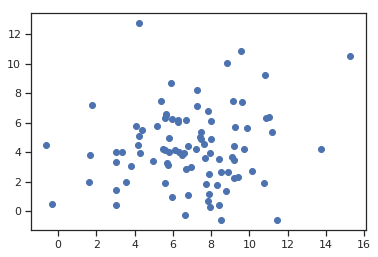

In [74]:
plt.scatter(ohnologs_goi['AS_WT_cont_mean_low'], ohnologs_goi['AS_WT_cont_mean_high'])

In [75]:
colors = {'low': 'blue', 'high': 'red'}

hover_text = []
for ind, row in ohnologs_goi.iterrows():
    hover_text.append(('Low Paralog: {SC_common_name_low}<br>  LFC: {LFC_low:.2f}<br>  -log10(pval): {pval_low:.2f}<br>' +
                       'High Paralog: {SC_common_name_high}<br>  LFC: {LFC_high:.2f}<br>  -log10(pval): {pval_high:.2f}').format(
                        SC_common_name_low = row['SC_common_name_low'],
                        LFC_low = row['log2FoldChange_low'],
                        pval_low = -np.log10(row['pvalue_low']),
                        SC_common_name_high = row['SC_common_name_high'],
                        LFC_high = row['log2FoldChange_high'],
                        pval_high = -np.log10(row['pvalue_high']))
                      )
data = []

for level in ['low','high']:
    trace = pygo.Scatter(
                x = ohnologs_goi['AS_WT_cont_mean_' + level], 
                y =  ohnologs_goi['AS_WT_drug_mean_' + level],
                text = hover_text,
                mode = 'markers',
                marker = {'opacity': 0.9,  
                          'color': colors[level],
                          'size': 10}, 
                name = level + ' induction paralogs'
            )

    data.append(trace)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": 'rlog -drug'
    },
    yaxis= {
        #"range":[-10, 10],
        "title": 'rlog +drug'
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename= 'rlog_for_paralogs')

C:\Users\BMH_work\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



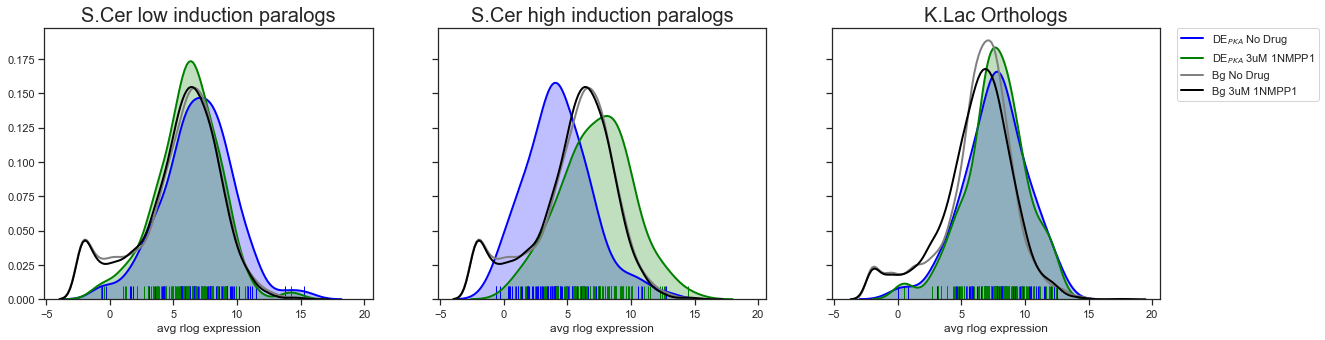

In [67]:
## Make Histograms (put dots on x axis)

fig, axarr = plt.subplots(1,3, sharex=True, sharey=True, figsize = [20,5])

level = 'low'

for jj, level in enumerate(['low','high']):
    ax = axarr[jj]
    sns.distplot(ohnologs_goi['AS_WT_cont_mean_' + level], hist=False, rug=True, ax=ax, 
                 rug_kws={"color": "blue"},
                 kde_kws={"color": "blue", "shade":True, "lw": 2, "label": "DE$_{PKA}$ No Drug"})
    sns.distplot(ohnologs_goi['AS_WT_drug_mean_' + level], hist=False, rug=True, ax=ax, 
                 rug_kws={"color": "green"},
                 kde_kws={"color": "green", "shade":True, "lw": 2, "label": "DE$_{PKA}$ 3uM 1NMPP1"})
    sns.distplot(rlog_data_mean_var['SC']['AS_WT_cont_mean'], hist=False, ax=ax,
                 kde_kws={"color": "grey",  "lw": 2, "label": "Bg No Drug"})
    sns.distplot(rlog_data_mean_var['SC']['AS_WT_drug_mean'], hist=False, ax=ax,
                 kde_kws={"color": "black",  "lw": 2, "label": "Bg 3uM 1NMPP1"})

    ax.get_legend().remove()
    ax.set_xlabel('avg rlog expression')
    ax.set_title('S.Cer ' + level + ' induction paralogs', fontsize = 20)



ax = axarr[2]
sns.distplot(ohnologs_goi_klorth_rlog['AS_WT_cont_mean'], hist=False, rug=True, ax=ax, 
             rug_kws={"color": "blue"},
             kde_kws={"color": "blue", "shade":True, "lw": 2, "label": "DE$_{PKA}$ No Drug"})
sns.distplot(ohnologs_goi_klorth_rlog['AS_WT_drug_mean'], hist=False, rug=True, ax=ax, 
             rug_kws={"color": "green"},
             kde_kws={"color": "green", "shade":True, "lw": 2, "label": "DE$_{PKA}$ 3uM 1NMPP1"})
sns.distplot(rlog_data_mean_var['KL']['AS_WT_cont_mean'], hist=False, ax=ax,
             kde_kws={"color": "grey",  "lw": 2, "label": "Bg No Drug"})
sns.distplot(rlog_data_mean_var['KL']['AS_WT_drug_mean'], hist=False, ax=ax,
             kde_kws={"color": "black",  "lw": 2, "label": "Bg 3uM 1NMPP1"})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('avg rlog expression')
ax.set_title('K.Lac Orthologs', fontsize = 20)



    
fig.savefig(os.path.normpath("C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/SC_KL_DEpka_induction_blue_green.svg"))  

    

Figure [rlog gois]:  K.Lactis orthologs of the WGH paralogs with differential induction in response to PKA inhibition tend to have constitutive and relatively high expression levels.  This is similar to the low-induction S.Cerevisiae WGH paralogs. Kernel density estimates for average rlog data for the indicated sets of gens are plotted with (green) and without (blue) treatment with 3uM NMPP1 (green).  Data is shown as ticks on the x axis.  The background for the S.Cer genes is all S.Cer genes, and for K.Lac orthologs is all K.Lac genes.  
Note: For the S.Cer genes there are 91 paralog pairs that meet my criteria for differential expression.  87 of those have K.Lac Orthologs

In [89]:
gtf_fname = "/home/heineike/genomes/scer_20181114/saccharomyces_cerevisiae_R64-2-2_20170117.gff"
db_fname = "/home/heineike/genomes/scer_20181114/saccharomyces_cerevisiae_R64-2-2_20170117.db"
db_created = True

if db_created: 
    db = gffutils.FeatureDB(db_fname)
else: 
    db = gffutils.create_db(gtf_fname, db_fname)

sc_features = pd.read_sql('select * from features;', db.conn)

sc_genes = sc_features[sc_features['featuretype']=='gene']

dubious_orfs = []
for row in sc_genes.iterrows():
    attributes = row[1]['attributes'].strip("{}").split(",")
    for attribute in attributes: 
        if attribute.split(":")[0]=='"orf_classification"':
            if attribute.split(":")[1]=='["Dubious"]':
                dubious_orfs.append(row[1]['id'])
print("There are {} dubious orfs in the saccharomyces_cerevisiae_R64-2-2_20170117.gff".format(len(dubious_orfs)))

There are 689 dubious orfs in the saccharomyces_cerevisiae_R64-2-2_20170117.gff


In [21]:
print('{} dubious orfs were removed from the rlog data set. {} total genes, {} in filtered set'.format(
     len(set(rlog_data_mean_var['SC'].index)&set(dubious_orfs)),
     len(rlog_data_mean_var['SC']), 
     len(rlog_data_mean_var_nodub)
     ))
      

443 dubious orfs were removed from the rlog data set. 6050 total genes, 5607 in filtered set


mean for DEpka high_cont: 4.32388195262562 +/- 2.6068221093000283
mean for all cont: 5.9085129147129285 +/- 2.9691054619586503
mean for DEpka high_drug: 7.254367534252784 +/- 2.7640825751623765
mean for all drug: 5.857474289744664 +/- 2.8801969399409355
mean for DEpka low_cont: 6.902454893033382 +/- 2.7654407953834874
mean for all cont: 5.9085129147129285 +/- 2.9691054619586503
mean for DEpka low_drug: 6.144416073263761 +/- 2.4879778794031955
mean for all drug: 5.857474289744664 +/- 2.8801969399409355
mean for DEpka orthologs cont: 7.653168776639845 +/- 2.488714472379547
mean for all cont: 6.28673704532881 +/- 2.9350454711880674
mean for DEpka orthologs drug: 7.6714658200689625 +/- 2.4123157534430923
mean for all drug: 6.1418350443894525 +/- 2.9541035134100135


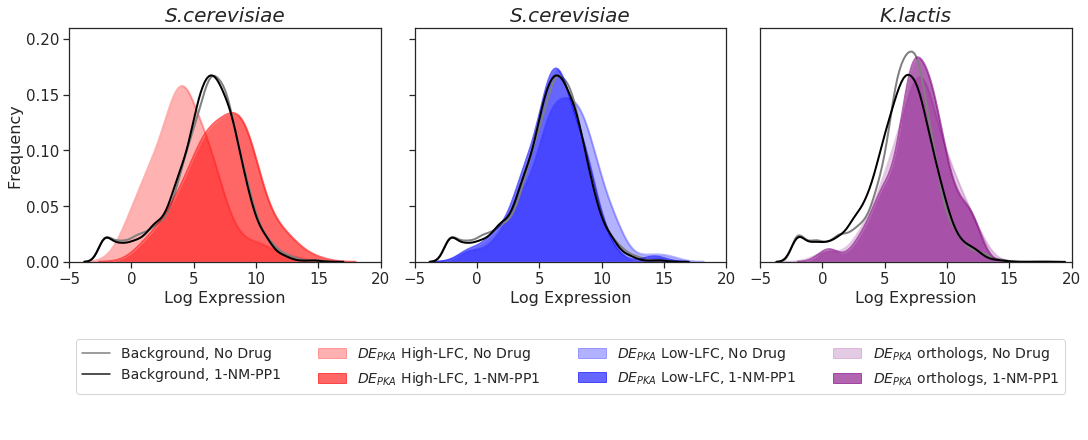

In [123]:
## Histograms:  Color coding/hatching, no dots. 

fig = plt.figure(constrained_layout=True, figsize=(15,6))
gs = fig.add_gridspec(2,3, width_ratios=[1,1,1], height_ratios = [5,2] )
#fig_pct, axarr = plt.subplots(1,3, figsize=(10,20), gridspec_kw={'width_ratios': [1, 20,1]})

axarr = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])]
ax_legend = fig.add_subplot(gs[1,:])

xmin = -5
xmax = 20
ymin = 0
ymax = 0.21
yticks = [0,0.05,0.10,0.15, 0.20]

#     ax_hmap = 
# ax_pct = fig_pct.add_subplot(gs[:,1])
# ax_cbar = fig_pct.add_subplot(gs[1,2])

#fig, axarr = plt.subplots(1,3, sharex=True, sharey=True, figsize = [20,5])

color_alpha = {'low_cont':('#0000ff',0.3),
              'low_drug':('#0000ff',0.6),
              'high_cont':('red',0.3), 
              'high_drug': ('red', 0.6) ,
              'klac_cont': ('purple', 0.2),
              'klac_drug': ('purple', 0.6)
             }
cond_labels = {'cont': 'No Drug', 'drug': '1-NM-PP1'}
level_titles = {'low': ('S.cerevisiae', '$DE_{PKA}$ Low-LFC'), 
                'high': ('S.cerevisiae', '$DE_{PKA}$ High-LFC')}
bg_colors = {'cont': 'grey', 'drug': 'black'}


legend_elements = [Line2D([0], [0], color='grey', label='Background, No Drug'),
                   Line2D([0], [0], color='k', label='Background, 1-NM-PP1')]

for jj, level in enumerate(['high', 'low']):
    ax = axarr[jj]
    for cond in ['cont','drug']:
        color , alpha = color_alpha[level + '_' + cond]
        rlog_data_mean_var_nodub = rlog_data_mean_var['SC'].loc[set(rlog_data_mean_var['SC'].index)-set(dubious_orfs),:]
        print("mean for DEpka {}: {} +/- {}".format(level+ '_' + cond,
                                               ohnologs_goi['AS_WT_' + cond + '_mean_' + level].mean(), 
                                               ohnologs_goi['AS_WT_' + cond + '_mean_' + level].std()
                                              ))
        print("mean for all {}: {} +/- {}".format(cond,
                                               rlog_data_mean_var_nodub['AS_WT_'+ cond +'_mean'].mean(), 
                                               rlog_data_mean_var_nodub['AS_WT_'+ cond +'_mean'].std()
                                              ))
        sns.distplot(ohnologs_goi['AS_WT_' + cond + '_mean_' + level], hist=False, rug=False, ax=ax, 
                    #rug_kws={"color": "blue"},
                    kde_kws={"color": color, "shade":True, "lw": 2, "alpha":alpha} )  #
        sns.distplot(rlog_data_mean_var_nodub['AS_WT_'+ cond +'_mean'], hist=False, ax=ax,
                     kde_kws={"color": bg_colors[cond],  "lw": 2})
        legend_elements.append(Patch(facecolor=color, alpha = alpha, edgecolor=color, label=level_titles[level][1] + ', ' + cond_labels[cond]) )
    
    ax.tick_params(labelsize = 15)
    ax.set_xlabel('Log Expression', fontsize=16)
    ax.set_title(level_titles[level][0], fontsize = 20, fontdict={'style':'italic'})
    ax.set_yticks(yticks)
    if jj==0:
        ax.set_yticklabels(['{:0.2f}'.format(ytick) for ytick in yticks])
        ax.set_ylabel('Frequency', fontsize=16)
    else:
        ax.set_yticklabels([])
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    #ax.legend().remove()
    #ax.legend(prop={'size':18})


    

level='klac'
ax = axarr[2]
for cond in ['cont','drug']:
    color , alpha = color_alpha[level + '_' + cond]
    print("mean for DEpka orthologs {}: {} +/- {}".format(cond,
                                           ohnologs_goi_klorth_rlog['AS_WT_' + cond + '_mean'].mean(), 
                                           ohnologs_goi_klorth_rlog['AS_WT_' + cond + '_mean'].std()
                                          ))
    print("mean for all {}: {} +/- {}".format(cond,
                                           rlog_data_mean_var['KL']['AS_WT_'+ cond +'_mean'].mean(), 
                                           rlog_data_mean_var['KL']['AS_WT_'+ cond +'_mean'].std()
                                          ))
    sns.distplot(ohnologs_goi_klorth_rlog['AS_WT_' + cond + '_mean'], hist=False, rug=False, ax=ax, 
        #rug_kws={"color": "blue"},
        kde_kws={"color": color, "shade":True, "lw": 2, "alpha":alpha }) # , "label": cond_labels[cond], })
    sns.distplot(rlog_data_mean_var['KL']['AS_WT_'+ cond +'_mean'], hist=False, ax=ax,
         kde_kws={"color": bg_colors[cond],  "lw": 2})
    legend_elements.append(Patch(facecolor=color, alpha = alpha, edgecolor=color, label='$DE_{PKA}$ orthologs, ' + cond_labels[cond]) )
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax.legend().remove()
ax.set_xlabel('Log Expression', fontsize=16)
ax.tick_params(labelsize = 15)
ax.set_title('K.lactis', fontsize = 20, fontdict={'style':'italic'})
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

#ax.legend(prop={'size':18})




# for 
#                    #       markerfacecolor='g', markersize=15),
#                    Patch(facecolor='red', alpha =0.45,  edgecolor='red',
#                          label='Ohnologs'), 
#                    Patch(facecolor='grey', alpha = 0.45, edgecolor='grey',
#                          label='Other genes') 
# #                    Patch(facecolor=act_rep_color, edgecolor=act_rep_color,
# #                          label='One ohnolog activated, one ohnolog repressed'), 
# #                    Patch(facecolor=no_eff_color, edgecolor=no_eff_color,
# #                          label='Not effected by PKA inhibition'), 
# #                    Patch(fill=False, edgecolor= 'grey', hatch = '///',
# #                          label='$DE_{PKA}$') 
#                     ]

#ax.legend(bbox_to_anchor=(1.05,1.0))
ax_legend.legend(handles=legend_elements, mode='expand', ncol=4, loc = 10, prop={'size':14})  #, bbox_to_anchor=(0.0, 1.3), loc=2, borderaxespad= 0.) #, loc='center')
ax_legend.set_axis_off()
    
fig.savefig(figsave_dir + 'SC_KL_DEpka_induction.svg')  

    

C:\Users\BMH_work\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0, 0.5, '')

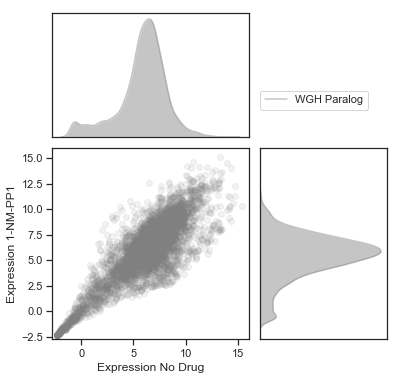

In [35]:
#seemed strange that there wasn't very much difference between +/- drug for S.Cer.  This checks it

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(5, 5, hspace=0.2, wspace=0.2)
ax_scatter = fig.add_subplot(grid[2:,0:-2])
ax_xhist = fig.add_subplot(grid[0:2,0:-2 ], xticks=[],yticks=[]) #, sharey=ax_scatter)
ax_yhist = fig.add_subplot(grid[2:,-2:], xticks=[],yticks=[]) #, sharex=ax_scatter)

# subsets = OrderedDict({'Not Wgh Paralog': (1,'gray', 0.2,0.45 ),
#                        'WGH Paralog': (2,'red', 0.2,0.45)
#                      })


#for subset_name, (N_paralogs, color, alpha, alpha_kde) in subsets.items(): 

alpha = 0.1
color = 'grey'
alpha_kde = 0.45
xdata = rlog_data_mean_var['KL']['AS_WT_cont_mean']
ydata = rlog_data_mean_var['KL']['AS_WT_drug_mean']   

ax_scatter.scatter(xdata, ydata, color=color, alpha=alpha)
sns.distplot(xdata, hist=False, rug=False, ax=ax_xhist, 
             kde_kws={"color": color, "shade":True,  "label": subset_name, "alpha": alpha_kde}) #"lw": 2,
sns.distplot(ydata, hist=False, rug=False, ax=ax_yhist, 
             kde_kws={"color": color, "shade":True, "label": subset_name, "alpha":alpha_kde}, vertical=True) #"lw": 2, 
    #ax_yhist.invert_xaxis()
#sns.jointplot(x = subset['log2FoldChange_KL'] , y = subset['log2FoldChange_SC'], kind='kde', color = color, ax = ax)
#     sns.distplot(subset['log2FoldChange_SC'], hist=False, rug=False, ax=ax, 
#                  kde_kws={"color": color, "shade":True, "lw": 2, "label": subset_name})
  
    
ax_scatter.set_xlim([-2.75,16])
ax_scatter.set_ylim([-2.75,16])
ax_scatter.set_xlabel('Expression No Drug')
ax_scatter.set_ylabel('Expression 1-NM-PP1')

ax_yhist.legend(bbox_to_anchor=(0.0, 1.3), loc=2, borderaxespad=0.)
kl_legend = ax_xhist.legend()
kl_legend.remove()
ax_xhist.set_xlabel('')
ax_yhist.set_ylabel('')


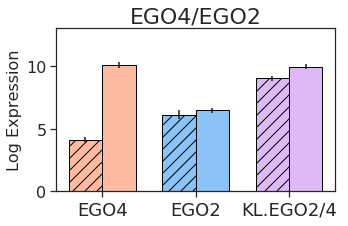

In [151]:
#Individual gene plot

high_gene = 'YNR034W-A'  #'GPM2'#'GND2'#   ENO1
legend_labels_dict = {'YNR034W-A': ['EGO4', 'EGO2', 'KL.EGO2/4'], 
                      'ENO1': ['ENO1', 'ENO2', 'KL.ENO1/2'],
                      'PYK2': ['PYK2', 'CDC19','KL.PYK'], 
                      'FMP43': ['MPC3', 'MPC2' , 'KL.MPC'], 
                      'GPM2': ['GPM2','GPM3','KL.GPM2/3'], 
                      'EMP46': ['EMP46','EMP47','KL.EMP46/47'], 
                      'GND2': ['GND2','GND1','KL.GND1/2']
                     }

row = ohnologs_goi_klorth_rlog[ohnologs_goi_klorth_rlog['SC_common_name_high']==high_gene]

fig_bar, ax_bar = plt.subplots(1,1, figsize=(5,3), sharex = True)
bw = 1.0
opacity = 1.0
spacing = 0.8

hatch_dict = OrderedDict([('cont','//'), ('drug','')])

#prefix, suffix, color
plot_props_dict = OrderedDict([('high', ['AS_WT_','_high', '#fcbba1']),    #red
                               ('low', ['AS_WT_', '_low', '#8cc3f6']),  #'#8bd3f4'
                               ('kl', ['AS_WT_','', "#deb9f6"])  #purple
                              ])

# for jj, quantity_to_view in enumerate(['pct', 'avg']):  
#     ax_bar = axs_bar[jj]
index = []
data = []
var = []
colors = []
hatches = []
tick_locs = []

for jj, (label, (prefix,suffix, color)) in enumerate(plot_props_dict.items()): 
    tick_locs.append(jj*(len(hatch_dict)+spacing) + 0.5)
    
    for kk, (cond, hatch) in enumerate(hatch_dict.items()):
        index.append(jj*(len(hatch_dict)+spacing) + kk)
        data.append(row[prefix + cond + '_mean' + suffix].values[0])
        var.append(np.sqrt(row[prefix + cond + '_var' + suffix].values[0]))
        hatches.append(hatch)
        colors.append(color)


bar_plot = ax_bar.bar(index,data, bw,
                     yerr = var,
                     alpha=opacity,
                     color=colors, 
                     edgecolor = 'black' 
#                      label=legend_labels[spec]
                    ) 

for kk, bar in enumerate(bar_plot):
    hatch = hatches[kk]
    bar.set_hatch(hatch)
#     bar_set = bar_sets[spec][kk]
#     plot_props[bar_set][3]=bar
#         bar_plots.append(bar_plot)
#         legend_label_list.append(legend_labels[spec]) 
    
    
#     ymax = max(data['Scer'] + data['Klac'] + [1.0]) + 0.2
#     ax_bar.vlines([len(index['Scer'])], ymin = 0, ymax = ymax, colors = 'gray',linewidth=3)
ax_bar.set_xticklabels(legend_labels_dict[high_gene], fontsize=18)
#ax_bar.set_xticklabels(list(plot_props_dict.keys()))
ax_bar.set_xticks(tick_locs)
ax_bar.tick_params(axis='y', labelsize=16)
ax_bar.set_title(legend_labels_dict[high_gene][0] + '/'+legend_labels_dict[high_gene][1], fontsize = 22)
ax_bar.set_ylabel('Log Expression', fontsize=16)
ax_bar.set_ylim([0,13])


#remember to move figure to laptop
fig_bar.savefig(os.path.normpath(figsave_dir + 'mydata_' + high_gene +'.svg'))


In [30]:
row.columns
#row['AS_WT_cont_mean_low']
row['AS_WT_cont_var_low']

25    0.866678
Name: AS_WT_cont_var_low, dtype: float64

In [ ]:
LFC and standard error from cross_species_compare_ASminus_ASplus_YPD_20181204
Rlog taken from ohnologs_goi_klorth_rlog in this file
Msn2/4 del data taken from 20181017_deseq_SC_AS_M24_nmpp1

EGO2:0.41+/-0.37
low: 6.09+/-0.12
EGO4:7.16+/-0.38
    4.12+/-0.04
    Msn2/4 del 1.45+/-0.6
KLEGO2/4: 1.06 +/-0.29

GPM3: -0.26 +/-0.75
    3.79 +/- 0.87
GPM2: 5.16 +/-0.52
    3.02 +/- 0.34
KLGPM2/3: 2.36+/-0.33
    
GND2: 7.77+/-0.40
GND1: -2.40+/-0.52
KLGND1/2: 0.17+/-0.38

In [13]:
row.columns

Index(['Ancestor', 'AA %id', 'Length Ratio', 'sc_genename_low',
       'SC_common_name_low', 'log2FoldChange_low', 'pvalue_low',
       'AS_WT_drug_mean_low', 'AS_WT_drug_var_low', 'AS_WT_cont_mean_low',
       'AS_WT_cont_var_low', 'sc_genename_high', 'SC_common_name_high',
       'log2FoldChange_high', 'pvalue_high', 'AS_WT_drug_mean_high',
       'AS_WT_drug_var_high', 'AS_WT_cont_mean_high', 'AS_WT_cont_var_high',
       'N SCer Orthologs', 'kl_genename', 'sc_genename', 'AS_M24_cont_mean',
       'AS_M24_drug_mean', 'AS_RGM24_cont_mean', 'AS_RGM24_drug_mean',
       'AS_RG_cont_mean', 'AS_RG_drug_mean', 'AS_WT_cont_mean',
       'AS_WT_drug_mean', 'WT_WT_cont_mean', 'WT_WT_drug_mean',
       'AS_M24_cont_var', 'AS_M24_drug_var', 'AS_RGM24_cont_var',
       'AS_RGM24_drug_var', 'AS_RG_cont_var', 'AS_RG_drug_var',
       'AS_WT_cont_var', 'AS_WT_drug_var', 'WT_WT_cont_var', 'WT_WT_drug_var',
       'SC_common_name'],
      dtype='object')

In [102]:
kl_sc_PKA_data[kl_sc_PKA_data['SC_common_name']=='PYK2']

N SCer Orthologs   kl_genename sc_genename  baseMean_KL  \
4389                 2  KLLA0F23397g     YOR347C   494.180208   

      log2FoldChange_KL  lfcSE_KL   stat_KL  pvalue_KL   padj_KL  baseMean_SC  \
4389          -1.707789  0.996148 -1.714394   0.086456  0.142569    47.344838   

      log2FoldChange_SC  lfcSE_SC   stat_SC  pvalue_SC   padj_SC  \
4389           2.432765  0.566851  4.291719   0.000018  0.000069   

     SC_common_name  
4389           PYK2

In [ ]:
#Heatmaps for LFC and rlog

In [14]:
#Merge k.lac data with ohnolog_gois but leave blanks for missing data from KL
ohnologs_goi_klorth_left = ohnologs_goi.merge(kl_orthologs, how='left', left_on='sc_genename_low',right_on='sc_genename')
ohnologs_goi_klorth_rlog_left = ohnologs_goi_klorth_left.merge(rlog_data_mean_var['KL'], how = 'left', left_on='kl_genename', right_index = True)
#Merge LFC data from KL with rest of ohnolog data
ohnologs_goi_kl_data_left = ohnologs_goi_klorth_rlog_left.merge(kl_sc_PKA_data.loc[:,
                    ['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
                    'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL']],
                    how='left', left_on = 'sc_genename_high', right_on = 'sc_genename')  


#Sort by LFC high
ohnologs_goi_kl_data_left.sort_values(by='log2FoldChange_high', ascending=False, inplace=True)
ohnologs_goi_kl_data_left['SC_common_name_high_low'] = ohnologs_goi_kl_data_left['SC_common_name_high'] + '_' + ohnologs_goi_kl_data_left['SC_common_name_low']
ohnologs_goi_kl_data_left.set_index('SC_common_name_high_low', inplace=True)


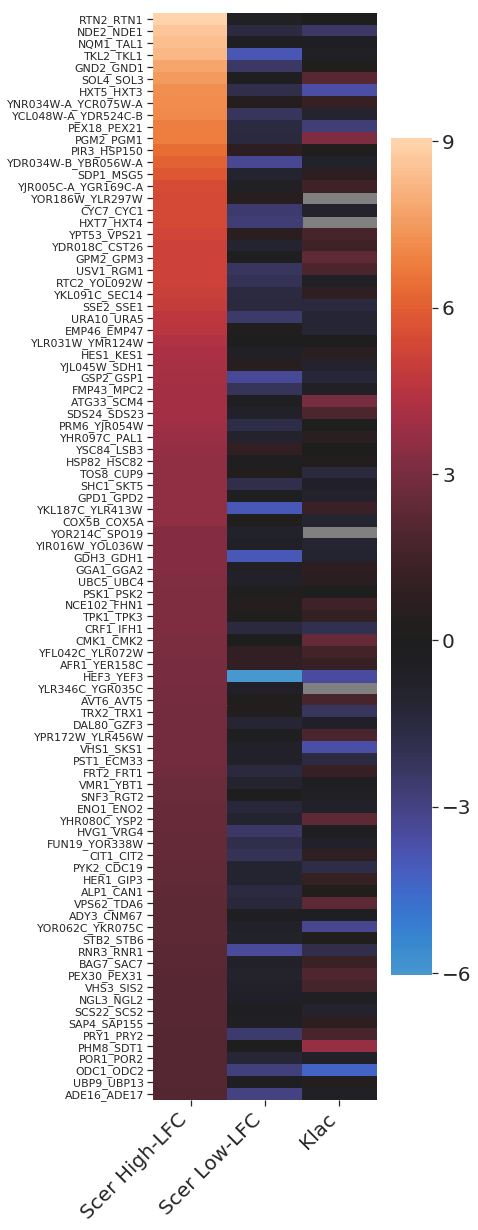

In [16]:
## Using same order and column names, visualize my rlog data

lfc_sc_kl = ohnologs_goi_kl_data_left.loc[:, ['log2FoldChange_high', 'log2FoldChange_low', 'log2FoldChange_KL']]

fig_lfc, ax_lfc = plt.subplots(figsize=(5,20))

sns.heatmap(lfc_sc_kl, center = 0.0, ax=ax_lfc)

ax_lfc.set_facecolor("grey")
ax_lfc.set_xticklabels(['Scer High-LFC', 'Scer Low-LFC', 'Klac'], fontdict={'fontsize':20, 'rotation':45, 'horizontalalignment':'right'})
ax_lfc.set_ylabel('')

cbar = ax_lfc.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)



fig_lfc.savefig(figsave_dir + 'LFC_goi.svg')

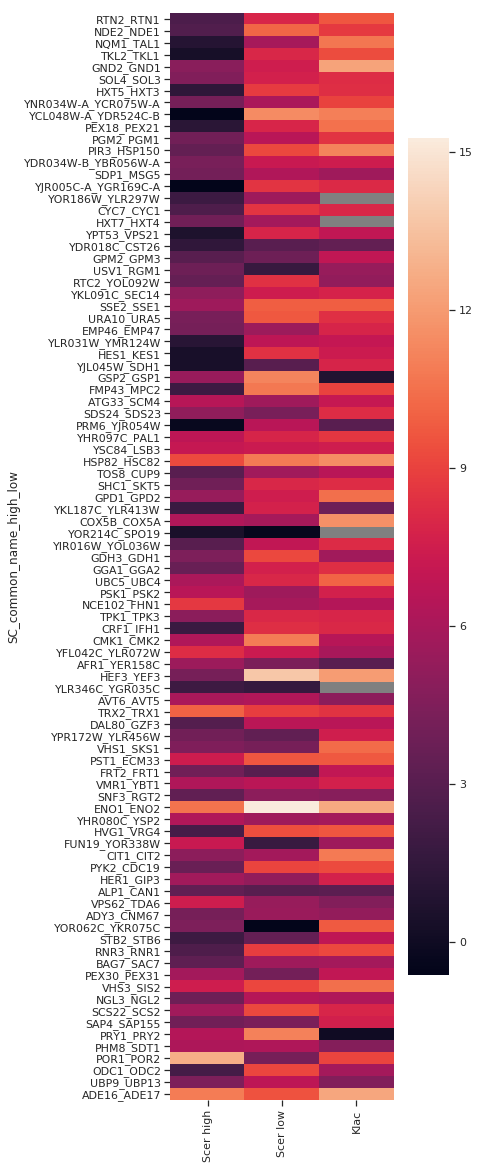

In [25]:
rlog_sorted = ohnologs_goi_kl_data_left.loc[:,['AS_WT_cont_mean_high', 'AS_WT_cont_mean_low', 'AS_WT_cont_mean']]

fig_rlog, ax_rlog = plt.subplots(figsize=(5,20))

sns.heatmap(rlog_sorted,ax=ax_rlog)

ax_rlog.set_facecolor("grey")
ax_rlog.set_xticklabels(['Scer high', 'Scer low','Klac'])

fig_rlog.savefig(os.path.normpath(figsave_dir + 'rlog_goi.svg'))

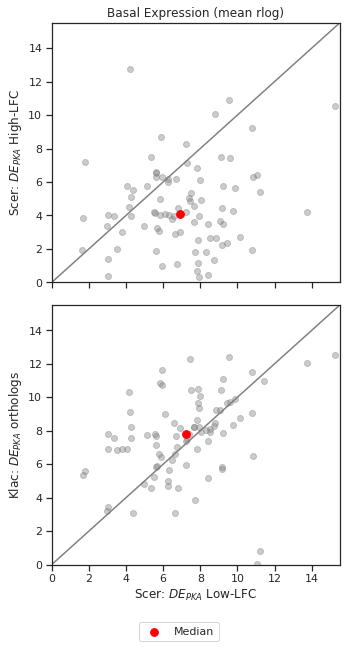

In [19]:
## Plot Scatter of rLog low/high, low, K.lac
fig, axarr = plt.subplots(2,1, figsize=(5,9)) 

level_titles = {'low': 'Scer: $DE_{PKA}$ Low-LFC ohnologs', 
                'high': 'Scer: $DE_{PKA}$ High-LFC ohnologs'}

#(axis_label, column)
data_info = {'high':  ('Scer: $DE_{PKA}$ High-LFC','AS_WT_cont_mean_high') , 
             'low' :  ('Scer: $DE_{PKA}$ Low-LFC', 'AS_WT_cont_mean_low') , 
             'kl'  :  ('Klac: $DE_{PKA}$ orthologs', 'AS_WT_cont_mean')}

(xdata_label, xdata_column) = data_info['low']

xmin, xmax = (0,15.5)
ymin, ymax = (xmin,xmax)

for jj, ydata_id in enumerate(['high', 'kl']):

    ax = axarr[jj]
    (ydata_label, ydata_column) = data_info[ydata_id]  
    
    xdata_raw = ohnologs_goi_kl_data_left[xdata_column]
    ydata_raw = ohnologs_goi_kl_data_left[ydata_column]
    
    xdata = xdata_raw[~np.isnan(ydata_raw)]
    ydata = ydata_raw[~np.isnan(ydata_raw)]
    
    ax.scatter(xdata, ydata, color='grey', alpha = 0.4, label = '_nolegend_')
    ax.plot([xmin,xmax],[ymin,ymax], color = 'grey')
    
    ax.scatter(np.median(xdata), np.median(ydata), color='red', s = 60, label = 'Median')
#     slope, intercept, r_value, p_value, std_err = stats.linregress(xdata, ydata)
#     print('regression for slope : {0:.2f}, intercept: {1:.2f}, R: {2:.2f}'.format(slope,intercept,r_value))
    
#     ax.plot([xmin,xmax],np.array([xmin, xmax])*slope + intercept, color = 'blue', linestyle = '--')
    
    ax.set_xlim([0,15.5])
    ax.set_ylim([0,15.5])
    ax.set_ylabel(ydata_label)
    if jj==0:
        ax.set_title('Basal Expression (mean rlog)')
        ax.set_xticklabels([])
    if jj==1:
        ax.legend(bbox_to_anchor = (0.6, -0.2))
        ax.set_xlabel(xdata_label)
    

#fig.subplots_adjust(hspace=0.3)
fig.tight_layout()

fig.savefig(figsave_dir + 'rlog_comparison.svg')

In [141]:
ohnologs_goi_kl_data_left

Ancestor AA %id  Length Ratio sc_genename_low  \
SC_common_name_high_low                                                   
RTN2_RTN1                Anc_8.454    25%          0.75         YDR233C   
NDE2_NDE1                Anc_2.382    57%          0.97         YMR145C   
NQM1_TAL1                Anc_4.188    68%          0.99         YLR354C   
TKL2_TKL1                Anc_3.372    71%          1.00         YPR074C   
GND2_GND1                 Anc_5.55    87%          0.99         YHR183W   
SOL4_SOL3                 Anc_5.78    48%          0.98         YHR163W   
HXT5_HXT3                Anc_5.396    70%          0.96         YDR345C   
YNR034W-A_YCR075W-A      Anc_6.348    18%          0.77       YCR075W-A   
YCL048W-A_YDR524C-B       Anc_1.22    48%          0.84       YDR524C-B   
PEX18_PEX21               Anc_5.86    12%          0.98         YGR239C   
PGM2_PGM1                Anc_2.445    79%          1.00         YKL127W   
PIR3_HSP150              Anc_1.188    74%          0.79         YJL159W   
YDR034W-B_YBR056W-A      Anc_3.267    49%          0.78       YBR056W-A   
SDP1_MSG5                Anc_2.256    41%          0.43         YNL053W   
YJR005C-A_YGR169C-A      Anc_5.173    61%          0.99       YGR169C-A   
YOR186W_YLR297W           Anc_6.93     5%          0.90         YLR297W   
CYC7_CYC1                Anc_1.482    83%          0.96         YJR048W   
HXT7_HXT4                Anc_5.394    81%          0.98         YHR092C   
YPT53_VPS21              Anc_2.196    56%          0.95         YOR089C   
YDR018C_CST26            Anc_3.244    37%          1.00         YBR042C   
GPM2_GPM3                Anc_3.172    67%          0.97         YOL056W   
USV1_RGM1                Anc_6.256    31%          0.54         YMR182C   
RTC2_YOL092W             Anc_3.105    59%          0.96         YOL092W   
YKL091C_SEC14            Anc_2.491    62%          0.98         YMR079W   
SSE2_SSE1                Anc_8.590    75%          1.00         YPL106C   
URA10_URA5               Anc_8.827    73%          1.00         YML106W   
EMP46_EMP47                Anc_8.2    40%          1.00         YFL048C   
YLR031W_YMR124W          Anc_2.414    25%          0.20         YMR124W   
HES1_KES1                Anc_8.658    69%          1.00         YPL145C   
YJL045W_SDH1             Anc_5.253    83%          0.99         YKL148C   
...                            ...    ...           ...             ...   
VHS1_SKS1                Anc_8.477    44%          0.92         YPL026C   
PST1_ECM33               Anc_3.302    54%          0.95         YBR078W   
FRT2_FRT1                 Anc_7.69    20%          0.88         YOR324C   
VMR1_YBT1                  Anc_4.6    51%          0.96         YLL048C   
SNF3_RGT2                Anc_7.309    57%          0.86         YDL138W   
ENO1_ENO2                 Anc_5.62    95%          1.00         YHR174W   
YHR080C_YSP2             Anc_5.370    36%          0.94         YDR326C   
HVG1_VRG4                Anc_3.538    76%          0.74         YGL225W   
FUN19_YOR338W             Anc_7.55    43%          0.88         YOR338W   
CIT1_CIT2                Anc_1.422    78%          0.96         YCR005C   
PYK2_CDC19                Anc_7.45    70%          0.99         YAL038W   
HER1_GIP3                Anc_8.648    44%          0.98         YPL137C   
ALP1_CAN1                 Anc_1.83    65%          0.97         YEL063C   
VPS62_TDA6               Anc_3.505    57%          1.00         YPR157W   
ADY3_CNM67                Anc_2.16    14%          0.74         YNL225C   
YOR062C_YKR075C          Anc_5.663    38%          0.87         YKR075C   
STB2_STB6                Anc_2.616    45%          0.90         YKL072W   
RNR3_RNR1                Anc_7.256    81%          0.98         YER070W   
BAG7_SAC7                Anc_5.471    39%          0.63         YDR389W   
PEX30_PEX31              Anc_4.140    41%          0.88         YGR004W   
VHS3_SIS2                Anc_5.655    47%          

In [146]:
#Compare Msn2/4 activation targets across species

y_data = 'kl' #'high'

#(axis_label, column)
data_info = {'high':  ('S.Cer: $DE_{PKA}$ High LFC','AS_WT_cont_mean_high') , 
             'low' :  ('S.Cer: $DE_{PKA}$ Low LFC', 'AS_WT_cont_mean_low') , 
             'kl'  :  ('K.Lac: $DE_{PKA}$ orthologs', 'AS_WT_cont_mean')}

(xdata_label, xdata_column) = data_info['low']
(ydata_label, ydata_column) = data_info[y_data]

xdata_raw = ohnologs_goi_kl_data_left[xdata_column]
ydata_raw = ohnologs_goi_kl_data_left[ydata_column]



data = []

# xlabel = 'LFC AS -/+ K.Lac'
# ylabel = 'LFC AS -/+ S.Cer'

# sc_target_set = set(msn24_sets['SC'][msn2_level]) 
# kl_target_set = set(kl_sc_PKA_data.loc[kl_sc_PKA_data['kl_genename'].isin(msn24_sets['KL'][msn2_level]),'sc_genename'])

# gene_subset = { 'Neither': set(kl_sc_PKA_data['sc_genename']) - (sc_target_set | kl_target_set),
#                 'KL only': kl_target_set-sc_target_set, 
#                 'SC only': sc_target_set-kl_target_set, 
#                 'Both': sc_target_set & kl_target_set
#                }
               
# colors = {'KL only':'blue', 
#           'SC only':'orange', 
#           'Both': 'purple', 
#           'Neither': 'gray'}

# for geneset_name, geneset in gene_subset.items():
    
#     kl_sc_PKA_data_subset = kl_sc_PKA_data[kl_sc_PKA_data['sc_genename'].isin(geneset)]
    
#     opacity = 0.8
#     if geneset_name == 'Neither':
#         opacity = 0.3
    
trace = pygo.Scatter(
            x = xdata_raw, 
            y =  ydata_raw,
            text = ohnologs_goi_kl_data_left.index,
            mode = 'markers',
#             marker = {'opacity': opacity,  
#                       'color': colors[geneset_name],
#                       'size': 10}, 
            name = 'Low v.s. ' + y_data
        )

data.append(trace)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": 'Low'
    },
    yaxis= {
        #"range":[-10, 10],
        "title": y_data
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename= 'rlog_DEPKA_low_vs_' + y_data)

## PKA, Msn24, and Rgm1/Gis1 targets

In [7]:
# Load gene lists from both species

gene_sets = {}

for spec in ['SC','KL']:
    fname = os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20181203_r1g1_m24_pka_targets_' + spec + '.pkl')   #20181128_r1g1_m24_pka_targets_' + spec + '_high_thresh.pkl')
    with open(fname, 'rb') as file:
        data = pickle.load(file)
        gene_set = data[0]
        gene_sets[spec] = gene_set


#NOTE: For M24 sets there might be a more recent set - 20190319
msn24_sets = {}

for spec in ['SC','KL']:
    fname = os.path.normpath(data_processing_dir + 'kl_sc_PKA_as_m24_r1g1_20181017/20181128_m24_pka_targets_vary_slope_' + spec + '.pkl')
    with open(fname, 'rb') as file:
        msn24_sets[spec] = pickle.load(file)
        

In [6]:
#Compare Msn2/4 activation targets across species

data = []

msn2_level = 'M_75'
#target_set = 'm24_nmpp1_act'

xlabel = 'LFC AS -/+ K.Lac'
ylabel = 'LFC AS -/+ S.Cer'

sc_target_set = set(msn24_sets['SC'][msn2_level]) 
kl_target_set = set(kl_sc_PKA_data.loc[kl_sc_PKA_data['kl_genename'].isin(msn24_sets['KL'][msn2_level]),'sc_genename'])

gene_subset = { 'Neither': set(kl_sc_PKA_data['sc_genename']) - (sc_target_set | kl_target_set),
                'KL only': kl_target_set-sc_target_set, 
                'SC only': sc_target_set-kl_target_set, 
                'Both': sc_target_set & kl_target_set
               }
               
colors = {'KL only':'blue', 
          'SC only':'orange', 
          'Both': 'purple', 
          'Neither': 'gray'}

for geneset_name, geneset in gene_subset.items():
    
    kl_sc_PKA_data_subset = kl_sc_PKA_data[kl_sc_PKA_data['sc_genename'].isin(geneset)]
    
    opacity = 0.8
    if geneset_name == 'Neither':
        opacity = 0.3
    
    trace = pygo.Scatter(
                x = kl_sc_PKA_data_subset['log2FoldChange_KL'], 
                y =  kl_sc_PKA_data_subset['log2FoldChange_SC'],
                text = kl_sc_PKA_data_subset['SC_common_name'],
                mode = 'markers',
                marker = {'opacity': opacity,  
                          'color': colors[geneset_name],
                          'size': 10}, 
                name = geneset_name
            )

    data.append(trace)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": xlabel
    },
    yaxis= {
        #"range":[-10, 10],
        "title": ylabel
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename= 'AS_pmNMPP1_kl_v_sc_' + msn2_level)

In [7]:
data = []

target_set = 'r1g1_rep'

xlabel = 'LFC AS -/+ K.Lac'
ylabel = 'LFC AS -/+ S.Cer'

sc_target_set = gene_sets['SC'][target_set]
kl_target_set = set(kl_sc_PKA_data.loc[kl_sc_PKA_data['kl_genename'].isin(gene_sets['KL'][target_set]),'sc_genename'])

gene_subset = { 'Neither': set(kl_sc_PKA_data['sc_genename']) - (sc_target_set | kl_target_set),
                'KL only': kl_target_set-sc_target_set, 
                'SC only': sc_target_set-kl_target_set, 
                'Both': sc_target_set & kl_target_set
               }
               
colors = {'KL only':'blue', 
          'SC only':'orange', 
          'Both': 'purple', 
          'Neither': 'gray'}

for geneset_name, geneset in gene_subset.items():
    
    kl_sc_PKA_data_subset = kl_sc_PKA_data[kl_sc_PKA_data['sc_genename'].isin(geneset)]
    
    opacity = 0.8
    if geneset_name == 'Neither':
        opacity = 0.3
    
    trace = pygo.Scatter(
                x = kl_sc_PKA_data_subset['log2FoldChange_KL'], 
                y =  kl_sc_PKA_data_subset['log2FoldChange_SC'],
                text = kl_sc_PKA_data_subset['SC_common_name'],
                mode = 'markers',
                marker = {'opacity': opacity,  
                          'color': colors[geneset_name],
                          'size': 10}, 
                name = geneset_name
            )

    data.append(trace)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": xlabel
    },
    yaxis= {
        #"range":[-10, 10],
        "title": ylabel
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename= 'AS_pmNMPP1_kl_v_sc_' + target_set)

In [15]:
gene_subset['Msn2/4 only']

{'EBG00000981576',
 'EBG00000981954',
 'EBG00000982249',
 'EBG00000982282',
 'KLLA0A00506g',
 'KLLA0A01221g',
 'KLLA0A02387g',
 'KLLA0A02629g',
 'KLLA0A02717g',
 'KLLA0A04081g',
 'KLLA0A04125g',
 'KLLA0A05852g',
 'KLLA0A09229g',
 'KLLA0A10527g',
 'KLLA0A11209g',
 'KLLA0B00803g',
 'KLLA0B04422g',
 'KLLA0B04543g',
 'KLLA0B04620g',
 'KLLA0B08800g',
 'KLLA0B09482g',
 'KLLA0B09526g',
 'KLLA0B09878g',
 'KLLA0B10263g',
 'KLLA0B11770g',
 'KLLA0B11792g',
 'KLLA0B12540g',
 'KLLA0B12672g',
 'KLLA0B12694g',
 'KLLA0B12760g',
 'KLLA0B12892g',
 'KLLA0B13123g',
 'KLLA0B14234g',
 'KLLA0B14751g',
 'KLLA0C01001g',
 'KLLA0C01177g',
 'KLLA0C02035g',
 'KLLA0C02937g',
 'KLLA0C04686g',
 'KLLA0C05324g',
 'KLLA0C05456g',
 'KLLA0C05940g',
 'KLLA0C06006g',
 'KLLA0C06072g',
 'KLLA0C08679g',
 'KLLA0C08888g',
 'KLLA0C10505g',
 'KLLA0C16027g',
 'KLLA0C16269g',
 'KLLA0C16489g',
 'KLLA0C17160g',
 'KLLA0C17886r',
 'KLLA0C17963g',
 'KLLA0C18117g',
 'KLLA0C18722g',
 'KLLA0C18909g',
 'KLLA0C19085g',
 'KLLA0C19132g',
 'KLLA

In [16]:
data = []

spec = 'KL'

msn2_level = 'M_75'

r1g1_rep_genes = gene_sets[spec]['r1g1_rep']
m24_nmpp1_act_genes = set(msn24_sets[spec][msn2_level])

xlabel = 'LFC AS -/+ K.Lac'
ylabel = 'LFC AS -/+ S.Cer'

gene_subset = { 'Neither': set(kl_sc_PKA_data[spec.lower() + '_genename']) - (r1g1_rep_genes | m24_nmpp1_act_genes),
                'Rph1/Gis1 only': r1g1_rep_genes - m24_nmpp1_act_genes, 
                'Msn2/4 only': m24_nmpp1_act_genes - r1g1_rep_genes, 
                'Both': r1g1_rep_genes & m24_nmpp1_act_genes
               }
               
colors = {'Rph1/Gis1 only':'blue', 
          'Msn2/4 only':'red', 
          'Both': 'green', 
          'Neither': 'gray'}

for geneset_name, geneset in gene_subset.items():
    
    kl_sc_PKA_data_subset = kl_sc_PKA_data[kl_sc_PKA_data[spec.lower() + '_genename'].isin(geneset)]
    
    opacity = 0.8
    if geneset_name == 'Neither':
        opacity = 0.3
    
    trace = pygo.Scatter(
                x = kl_sc_PKA_data_subset['log2FoldChange_KL'], 
                y =  kl_sc_PKA_data_subset['log2FoldChange_SC'],
                text = kl_sc_PKA_data_subset['SC_common_name'],
                mode = 'markers',
                marker = {'opacity': opacity,  
                          'color': colors[geneset_name],
                          'size': 10}, 
                name = geneset_name
            )

    data.append(trace)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": xlabel
    },
    yaxis= {
        #"range":[-10, 10],
        "title": ylabel
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename= 'AS_pmNMPP1_kl_v_sc_' + spec + '_r1g1_m24_'+msn2_level)

In [18]:
kl_sc_PKA_data[kl_sc_PKA_data['SC_common_name']=='GPA1']

N SCer Orthologs   kl_genename sc_genename  baseMean_KL  \
3238                 1  KLLA0F25916g     YHR005C   488.455583   

      log2FoldChange_KL  lfcSE_KL    stat_KL     pvalue_KL       padj_KL  \
3238           7.399321   0.55758  13.270415  3.436744e-40  2.080613e-38   

      baseMean_SC  log2FoldChange_SC  lfcSE_SC   stat_SC  pvalue_SC   padj_SC  \
3238   122.072697          -0.346963  0.364511 -0.951858   0.341169  0.463977   

     SC_common_name  
3238           GPA1

In [4]:
# #Not sure what this list of genes is for

# precursor = ['NDE2', 'GAC1', 'YJL045W', 'GLG1', 'GSM1', 'COX5B', 'COX20', 'CYC7', 'MBR1', 'GDB1', 'LSC2', 'AAC1', 'GSY2', 'PIG2', 'NDI1', 'RSF1', 'SHH4', 'SDH5', 'YLR345W', 'GSY1', 'ISF1', 'NCA2', 'GIP2', 'TDH1', 'MIX14', 'PSK1', 'SDH2', 'CIT1', 'ENO1', 'YMR31', 'RGI1', 'RGI2', 'YPI1', 'GLG2']
# resp = ['SHH4', 'MBR1', 'NDI1', 'SDH5', 'LSC2', 'SDH2', 'CIT1', 'YJL045W', 'AAC1', 'COX5B', 'YMR31', 'MIX14', 'ISF1', 'NCA2', 'COX20', 'CYC7', 'RSF1']
# set(precursor) - set(resp)
# #set(resp) - set(precursor)
